# Projet de taxation marginale à 75% sur les revenus > 1 Million €

### Introduction

Lors de la campagne présidentielle 2012 François Hollande annonça dans son programme électoral qu'il mettrait en place une taxe à 75% sur les revenus supérieurs à 1 million d'Euros. Durant cette période les partisans UMP affirmaient que ce projet de réforme ne pourrait jamais être implémenté et que ce n'était qu'un moyen pour François Hollande de gagner plus de voix aux élections. Pourtant en 2012 le gouvernement de François Hollande a proposé au conseil constitutionnel un projet de réforme de la fiscalité qui incluait une taxe marginale à hauteur de 75% pour les revenus supérieurs à 1 Millions d'Euros. Cette réforme a d'abord été invalidée par le Conseil Constitutionnel en Décembre de la même année, et elle a été refondue et revotée le 18 octobre 2013. Le 29 Décembre 2013 après avoir subit quelques rectifications, le projet de réforme fiscale est enfin validé par le Conseil Constitutionnel. Ainsi, alors que certains articles ont-été validés en l'état, d'autres on été rejetés complètement, et certains ont-été acceptés après avoir subit quelques modifications. Par exemple l'article 9 prévoyait en partie de faire passer le taux d'imposition sur les bons anonymes de 75,5% à 90,5%, ce qui a finalement été supprimé de la loi des finances 2013, car le Conseil Constitutionnel a jugé qu'un pareil taux représentait une charge trop importante au regard de la capacité contributive des contribuables. L'article 12, qui prévoyait d'instituer une taxe exceptionnelle de solidarité sur les revenus d'activité supérieure à 1 million d'euros, et dont le taux devait s'élever à 18%, a été supprimé. Enfin, l'article 3 qui a été validé par le Conseil Constitutionnel institue une nouvelle tranche d'imposition marginale à 45% sur les revenus supérieurs à 150.000 €. Conjugué avec d'autres articles, cette réforme fait passer la taxation marginale cumulée à plus de 75% sur les hauts revenus.

Cette réforme a beaucoup fait parler d'elle, d'abord parce qu'elle a été critiquée lors des campagnes présidentielles comme étant un simple projet démagogique, puis parce qu'une fois implémentée plusieurs personnalités françaises ont quitté le pays (Gérard Depardieux, Florent Pagny, Johnny Hallyday, Bernard Arnault...), laissant suggérer que cette réforme serait à l'origine d'un important exil fiscal. Etant donné l'importante médiatisation de cette réforme, et sachant qu'elle pourrait modifier le comportement des plus riches contribuables français, il semble intéressant d'étudier l'impacte de cette réforme sur la charge fiscale totale que doivent supporter les français.

Dans un premier temps il s'agira d'étudier la charge fiscale prévue par le projet initial en fonction du revenu imposable, et de la comparer avec la charge fiscale du projet modifié par le conseil constitutionnel. Sachant les avantages associés au quotient familiale ont-été modifié par la réforme, il s'agira dans un second temps de mesurer l'effet d'incitation au mariage de personnes avec des revenus disparates qui résulte du projet validé de réforme, et de le comparer avec le même effet d'incitation résultat du projet initial de réforme.

### Initialisation

In [1]:
from openfisca_france.tests import base

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True, precision=2) #permet d'imprimer les array avec juste 2 chiffres et sans notation scientifique.
from openfisca_matplotlib import graphs

In [3]:
from datetime import date  # module nécessaire pour la définition des dates, dont notamment les dates de naissances

from openfisca_core import periods
import openfisca_france    # module décrivant le système socio-fiscal français

TaxBenefitSystem = openfisca_france.init_country()  # Initialisation de la classe décrivant le système socio-fiscal français
tax_benefit_system = TaxBenefitSystem()  # Création d'une instance du système socio-fiscal français 
#tax_benefit_cesthra = Reform

### Reforme

En Septembre 2012, le projet de loi des finances 2013 fut présenté devant l'assemblée nationnale. L'article 8 de cette proposition prévoyait l'implémentation d'une "Contribution Exceptionnelle de Solidarité sur les très Hauts Revenus d'Activité" (CESRA), qui devait taxer à 18% la part des revenus professionnels excédant 1 million d'Euros. 

Ajouté au taux marginal d’impôt sur le revenu (IR) prévu dans le présent projet de loi de finances (45 %), à la
contribution exceptionnelle sur les hauts revenus (4 %) et aux prélèvements sociaux (8 % sur les revenus
d’activité), le taux marginal de taxation globale devait atteindre 75% de la part des revenus supérieurs à 1 millions d'euros.

J'ai remarqué en important la réforme que le taux marginal fixé pour la CESTRA était de 75%. Par conséquent j'obtenais des taux marginaux de taxation globale supérieurs à 100% (car sur les revenus supérieurs à 1 million d'euros les individus étaient taxé à 4% + 8% + 45% + 75% = 132%). Afin que la réforme importée correspondent précisément au projet de loi des finances 2013, j'ai remplacé le taux marginal de la CESTRA par 18% (on obtiens donc un taux marginal de 4% + 8% + 45% + 18% = 75% sur les revenus supérieurs à 1 million d'Euros)

### codage reforme :

In [6]:
from __future__ import division

import copy

import logging

from numpy import maximum as max_

from openfisca_core import columns, formulas, reforms
from openfisca_france import entities
from openfisca_france.model.impot_revenu import ir


log = logging.getLogger(__name__)

from openfisca_france.model.base import QUIFOY
VOUS = QUIFOY['vous']


class cesthra(formulas.SimpleFormulaColumn):
    column = columns.FloatCol
    entity_class = entities.FoyersFiscaux
    label = u"Contribution exceptionnelle de solidarité sur les très hauts revenus d'activité"
    # PLF 2013 (rejeté) : 'taxe à 75%'

    def function(self, simulation, period):
        period = period.start.offset('first-of', 'year').period('year')
        sal_holder = simulation.calculate("sal", period)
        law_cesthra = simulation.legislation_at(period.start).cesthra
        sal = self.split_by_roles(sal_holder)

        cesthra = 0
        for rev in sal.itervalues():
            cesthra += max_(rev - law_cesthra.seuil, 0) * law_cesthra.taux
        return period, cesthra


class irpp(formulas.SimpleFormulaColumn):
    label = u"Impôt sur le revenu des personnes physiques (réformée pour intégrer la cesthra)"
    reference = ir.irpp

    def function(self, simulation, period):
        '''
        Montant après seuil de recouvrement (hors ppe)
        '''
        period = period.start.offset('first-of', 'month').period('year')
        iai = simulation.calculate('iai', period)
        credits_impot = simulation.calculate('credits_impot', period)
        cehr = simulation.calculate('cehr', period)
        cesthra = simulation.calculate('cesthra', period = period)
        P = simulation.legislation_at(period.start).ir.recouvrement

        pre_result = iai - credits_impot + cehr + cesthra
        return period, ((iai > P.seuil) *
            ((pre_result < P.min) * (pre_result > 0) * iai * 0 +
            ((pre_result <= 0) + (pre_result >= P.min)) * (- pre_result)) +
            (iai <= P.seuil) * ((pre_result < 0) * (-pre_result) +
            (pre_result >= 0) * 0 * iai))


# Reform legislation

reform_legislation_subtree = {
    "cesthra": {
        "@type": "Node",
        "description": "Contribution execptionnelle sur les très hauts revenus d'activité",
        "children": {
            "seuil": {
                "@type": "Parameter",
                "description": "Seuil",
                "format": "integer",
                "unit": "currency",
                "values": [{'start': u'2012-01-01', 'stop': u'2013-12-31', 'value': 1000000}],
                },
            "taux": {
                "@type": "Parameter",
                "description": "Taux",
                "format": "rate",
                "unit": "currency",
                "values": [{'start': u'2012-01-01', 'stop': u'2013-12-31', 'value': .75}],
                },
            },
        },
    }




In [7]:
reference_legislation_json = tax_benefit_system.legislation_json
reform_legislation_json = copy.deepcopy(reference_legislation_json)
reform_legislation_json['children'].update(reform_legislation_subtree)
Reform = reforms.make_reform(
        legislation_json = reform_legislation_json,
        name = u"Contribution execptionnelle sur les très hauts revenus d'activité (invalidée par le CC)",
        new_formulas = (cesthra, irpp),
        reference = tax_benefit_system,
        )

### Taux marginaux:

Cotisations sociales

In [8]:
type(Reform)

type

## I. Différence de Taux Marginal entre les deux projets

Dans un premier temps nous allons confirmer que les taux marginaux de la CEHR (4% sur la part du revenu fiscal supérieur à 1.000.000 €), des prélèvement sociaux (8% sur les revenus d'activité) et de l'impot sur le revenu (45% sur la part des revenus supérieurs à 150.000 €) correspondent aux taux marginaux annoncé dans la loi des finances.

Ensuite nous ferons de même pour la CESRA et la TEHR.

### I.1. Projet initial: Contribution Exceptionnelle de Solidarité sur les trés Hauts Revenus d'Activité (CESRA)

In [11]:
tax_benefit_cesthra = Reform

In [12]:
def homme_celibataire_cesthra(salaire_minimal = 0, nombre_enfants = 0, number_of_year = 4 , salaire_maximal = 5000000):
    simulation = tax_benefit_cesthra.new_scenario().init_single_entity(
        axes = [
            dict(
                count = 100,
                min = salaire_minimal * number_of_year,
                max = salaire_maximal * number_of_year,
                name = 'salaire_de_base',
                ),
            ],
        period = '2010:{}'.format(number_of_year),
        parent1 = dict(
            birth = date(1980, 1, 1),
#            salaire_de_base = {"2013": salaire_maximal, "2014": salaire_maximal}
            ),
        menage = dict(
            loyer = 1000 * 3,
            so = 4,
            ),
        ).new_simulation(debug = True)
    return simulation

### Test de la simulation:

In [13]:
print homme_celibataire_cesthra(10**6).calculate('salaire_de_base', '2010')[-10:]
print homme_celibataire_cesthra().calculate('salaire_de_base', '2011')[-10:]
print homme_celibataire_cesthra().calculate('salaire_de_base', '2012')[-10:]
print homme_celibataire_cesthra().calculate('salaire_de_base', '2013')[-10:]
print homme_celibataire_cesthra().calculate('salaire_de_base', '2014')[-10:]



TypeError: unbound method new_scenario() must be called with Reform instance as first argument (got nothing instead)

In [450]:
salbrut_2013 =  homme_celibataire_cesthra().calculate('salbrut', '2013')
salbrut_2013

array([       0.  ,    50505.05,   101010.1 ,   151515.17,   202020.2 ,
         252525.23,   303030.34,   353535.34,   404040.41,   454545.41,
         505050.47,   555555.62,   606060.69,   656565.69,   707070.69,
         757575.75,   808080.81,   858585.81,   909090.81,   959595.81,
        1010100.94,  1060605.88,  1111111.25,  1161616.25,  1212121.38,
        1262626.38,  1313131.38,  1363636.38,  1414141.38,  1464646.5 ,
        1515151.5 ,  1565656.62,  1616161.62,  1666666.62,  1717171.62,
        1767676.62,  1818181.62,  1868686.62,  1919191.62,  1969696.88,
        2020201.88,  2070706.88,  2121211.75,  2171717.5 ,  2222222.5 ,
        2272727.5 ,  2323232.5 ,  2373737.5 ,  2424242.75,  2474747.75,
        2525252.75,  2575757.75,  2626262.75,  2676767.75,  2727272.75,
        2777777.75,  2828282.75,  2878788.  ,  2929293.  ,  2979798.  ,
        3030303.  ,  3080808.  ,  3131313.25,  3181818.25,  3232323.25,
        3282828.25,  3333333.25,  3383838.25,  3434343.25,  3484

In [451]:
revdisp_2013_cesthra = homme_celibataire_cesthra().calculate('revdisp', '2013')
revdisp_2013_cesthra

array([    6250.64,    36507.68,    69120.52,    97807.57,   125082.55,
         151207.56,   176884.09,   201584.03,   226283.98,   250984.  ,
         275683.97,   300359.56,   324584.5 ,   348809.56,   373034.53,
         397259.56,   421484.53,   445709.47,   469934.47,   494159.38,
         518384.5 ,   542609.5 ,   560165.88,   575840.88,   591515.88,
         607190.88,   622865.81,   638540.81,   654215.81,   669890.94,
         685565.81,   701240.81,   716915.81,   732590.81,   748265.81,
         763940.75,   779615.75,   795290.75,   810965.75,   826640.81,
         842315.75,   857990.75,   873665.75,   889341.  ,   905015.88,
         920691.  ,   936366.  ,   952040.88,   967716.  ,   983391.  ,
         999066.  ,  1014740.88,  1030415.88,  1046090.88,  1061765.88,
        1077440.88,  1093115.88,  1108791.  ,  1124465.88,  1140140.88,
        1155815.88,  1171490.88,  1187166.  ,  1202840.88,  1218516.  ,
        1234190.88,  1249865.88,  1265540.88,  1281215.88,  1296

#### Taux moyen de cotisation de salbrut au revenu disponible :

In [452]:
taux_cot_moy = (salbrut_2013 - revdisp_2013_cesthra)/salbrut_2013
taux_cot_moy

array([ -inf,  0.28,  0.32,  0.35,  0.38,  0.4 ,  0.42,  0.43,  0.44,
        0.45,  0.45,  0.46,  0.46,  0.47,  0.47,  0.48,  0.48,  0.48,
        0.48,  0.49,  0.49,  0.49,  0.5 ,  0.5 ,  0.51,  0.52,  0.53,
        0.53,  0.54,  0.54,  0.55,  0.55,  0.56,  0.56,  0.56,  0.57,
        0.57,  0.57,  0.58,  0.58,  0.58,  0.59,  0.59,  0.59,  0.59,
        0.59,  0.6 ,  0.6 ,  0.6 ,  0.6 ,  0.6 ,  0.61,  0.61,  0.61,
        0.61,  0.61,  0.61,  0.61,  0.62,  0.62,  0.62,  0.62,  0.62,
        0.62,  0.62,  0.62,  0.63,  0.63,  0.63,  0.63,  0.63,  0.63,
        0.63,  0.63,  0.63,  0.63,  0.63,  0.63,  0.63,  0.64,  0.64,
        0.64,  0.64,  0.64,  0.64,  0.64,  0.64,  0.64,  0.64,  0.64,
        0.64,  0.64,  0.64,  0.64,  0.64,  0.64,  0.65,  0.65,  0.65,  0.65], dtype=float32)

### Taux moyen de cotisations salariales :

In [453]:
np.set_printoptions(suppress=True, precision=6)
abs(
    homme_celibataire_cesthra().calculate('cotisations_salariales','2013') 
    + homme_celibataire_cesthra().calculate('csgsald','2013') 
    + homme_celibataire_cesthra().calculate('csgsali','2013')
    + homme_celibataire_cesthra().calculate('crdssal','2013')
    )/salbrut_2013

array([      nan,  0.190464,  0.155281,  0.14049 ,  0.127492,  0.119694,
        0.114494,  0.110781,  0.107996,  0.10583 ,  0.104097,  0.102679,
        0.101497,  0.100497,  0.099641,  0.098898,  0.098248,  0.097675,
        0.097165,  0.096709,  0.096298,  0.095927,  0.095589,  0.095281,
        0.094999,  0.094739,  0.094499,  0.094277,  0.09407 ,  0.093878,
        0.093699,  0.093531,  0.093374,  0.093226,  0.093087,  0.092956,
        0.092832,  0.092715,  0.092604,  0.092499,  0.092399,  0.092304,
        0.092214,  0.092127,  0.092045,  0.091966,  0.091891,  0.091818,
        0.091749,  0.091683,  0.091619,  0.091558,  0.091499,  0.091443,
        0.091388,  0.091336,  0.091285,  0.091236,  0.091189,  0.091144,
        0.091099,  0.091057,  0.091016,  0.090976,  0.090937,  0.0909  ,
        0.090863,  0.090828,  0.090794,  0.09076 ,  0.090728,  0.090697,
        0.090666,  0.090637,  0.090608,  0.09058 ,  0.090552,  0.090526,
        0.0905  ,  0.090474,  0.09045 ,  0.090426, 

In [454]:
print homme_celibataire_cesthra().calculate('cotisations_salariales','2013')/ salbrut_2012
print homme_celibataire_cesthra().calculate('csgsald','2013') / salbrut_2012
print homme_celibataire_cesthra().calculate('csgsali','2013')/ salbrut_2012
print homme_celibataire_cesthra().calculate('crdssal','2013')/ salbrut_2012


[      nan -0.111864 -0.076681 -0.061851 -0.048513 -0.04051  -0.035175
 -0.031364 -0.028507 -0.026283 -0.024505 -0.02305  -0.021838 -0.020812
 -0.019932 -0.01917  -0.018503 -0.017915 -0.017392 -0.016924 -0.016503
 -0.016121 -0.015775 -0.015459 -0.015169 -0.014902 -0.014656 -0.014428
 -0.014216 -0.014019 -0.013835 -0.013663 -0.013502 -0.01335  -0.013207
 -0.013073 -0.012946 -0.012826 -0.012712 -0.012604 -0.012501 -0.012404
 -0.012311 -0.012222 -0.012138 -0.012057 -0.011979 -0.011905 -0.011834
 -0.011766 -0.011701 -0.011638 -0.011578 -0.01152  -0.011464 -0.01141
 -0.011358 -0.011308 -0.01126  -0.011213 -0.011168 -0.011124 -0.011081
 -0.011041 -0.011001 -0.010962 -0.010925 -0.010889 -0.010854 -0.01082
 -0.010786 -0.010754 -0.010723 -0.010692 -0.010663 -0.010634 -0.010606
 -0.010579 -0.010552 -0.010526 -0.010501 -0.010476 -0.010452 -0.010428
 -0.010405 -0.010383 -0.010361 -0.01034  -0.010319 -0.010298 -0.010278
 -0.010259 -0.01024  -0.010221 -0.010203 -0.010185 -0.010167 -0.01015
 -0.01013

In [23]:
np.set_printoptions(suppress=True, precision=4)

In [24]:
Taux marginal de cotisation sociale :

SyntaxError: invalid syntax (<ipython-input-24-3466f920cddc>, line 1)

In [455]:
cotsoc= abs(
        homme_celibataire_cesthra().calculate('cotisations_salariales','2013') 
        + homme_celibataire_cesthra().calculate('csgsald','2013') 
        + homme_celibataire_cesthra().calculate('csgsali','2013')
        + homme_celibataire_cesthra().calculate('crdssal','2013'))

In [456]:
taux_marginal_cotsoc = (cotsoc[1:]- cotsoc[:-1]) / ( salbrut_2013[1:] - salbrut_2013[:-1])

In [457]:
print taux_marginal_cotsoc

[ 0.190464  0.120099  0.110907  0.088499  0.088499  0.088499  0.088501
  0.088501  0.088499  0.088501  0.088499  0.088501  0.088497  0.088501
  0.088499  0.088501  0.088501  0.088499  0.088501  0.088499  0.088499
  0.088498  0.088501  0.088502  0.088499  0.088502  0.088499  0.088502
  0.088497  0.088501  0.088501  0.0885    0.088501  0.088499  0.088501
  0.0885    0.088499  0.088498  0.088502  0.088502  0.088498  0.088502
  0.088498  0.088501  0.088497  0.088501  0.088501  0.088499  0.088501
  0.088499  0.088502  0.088499  0.0885    0.088501  0.088499  0.088502
  0.088498  0.088502  0.088499  0.088501  0.088497  0.088502  0.088502
  0.088499  0.0885    0.088501  0.088501  0.088499  0.088499  0.088501
  0.088499  0.088503  0.088498  0.088501  0.088499  0.088501  0.0885
  0.088498  0.088502  0.088498  0.088501  0.0885    0.088501  0.088502
  0.088497  0.088499  0.088501  0.088499  0.088501  0.088498  0.088502
  0.088499  0.088502  0.088498  0.0885    0.088499  0.088503  0.088498
  0.0885

In [99]:
cehr_h_celibataire = homme_celibataire_cesthra().calculate('cehr','2013') 
print cehr_h_celibataire

[      0.             0.             0.             0.             0.
       0.           448.535614    1873.53186     3298.530029    4723.530762
    6148.529297    7598.044922    9498.042969   11398.047852   13298.042969
   15198.044922   17098.042969   18998.037109   20898.037109   22798.033203
   24698.039062   26598.037109   28498.050781   30398.044922   32298.044922
   34198.046875   36098.039062   37998.039062   39898.039062   41798.050781
   43698.046875   45598.046875   47498.046875   49398.039062   51298.039062
   53198.035156   55098.03125    56998.03125    58898.035156   60798.039062
   62698.035156   64598.035156   66498.023438   68398.054688   70298.046875
   72198.046875   74098.0625     75998.039062   77898.046875   79798.046875
   81698.046875   83598.039062   85498.039062   87398.039062   89298.039062
   91198.039062   93098.039062   94998.046875   96898.039062   98798.039062
  100698.039062  102598.039062  104498.046875  106398.039062  108298.046875
  110198.039062  1

In [100]:
taux_marginal_cehr_h_celibataire = (cehr_h_celibataire[1:]- cehr_h_celibataire[:-1]) / ( salbrut_2013[1:] - salbrut_2013[:-1])
print taux_marginal_cehr_h_celibataire

[ 0.        0.        0.        0.        0.        0.008881  0.028215
  0.028215  0.028215  0.028215  0.0287    0.03762   0.03762   0.03762
  0.03762   0.03762   0.03762   0.03762   0.03762   0.03762   0.03762
  0.03762   0.03762   0.03762   0.03762   0.03762   0.03762   0.03762
  0.03762   0.03762   0.03762   0.03762   0.03762   0.03762   0.03762
  0.03762   0.03762   0.03762   0.03762   0.03762   0.03762   0.03762
  0.03762   0.03762   0.03762   0.03762   0.03762   0.03762   0.03762
  0.03762   0.03762   0.03762   0.03762   0.03762   0.03762   0.03762
  0.03762   0.03762   0.03762   0.03762   0.03762   0.03762   0.03762
  0.03762   0.03762   0.03762   0.03762   0.03762   0.03762   0.03762
  0.03762   0.03762   0.03762   0.03762   0.03762   0.03762   0.03762
  0.03762   0.03762   0.03762   0.03762   0.03762   0.03762   0.03762
  0.03762   0.03762   0.03762   0.03762   0.03762   0.03762   0.03762
  0.03762   0.03762   0.03762   0.03762   0.03762   0.03762   0.03762
  0.03762 ]


In [101]:
irpp_h_celibataire = homme_celibataire_cesthra().calculate('irpp','2013') 
print irpp_h_celibataire

[       0.          -5817.006348   -19082.617188   -36740.445312   -56965.5
   -78340.515625  -100164.101562  -122964.039062  -145764.015625
  -168564.03125   -191364.        -214188.578125  -237463.5625
  -260738.609375  -284013.53125   -307288.5625    -330563.53125
  -353838.46875   -377113.46875   -400388.4375    -423663.5       -446938.46875
  -476882.34375   -508707.21875   -540532.25      -572357.25      -604182.1875
  -636007.1875    -667832.1875    -699657.3125    -731482.3125
  -763307.3125    -795132.3125    -826957.1875    -858782.1875    -890607.125
  -922432.        -954257.        -986082.125    -1017907.1875   -1049732.125
 -1081557.125    -1113381.875    -1145207.375    -1177032.25     -1208857.25
 -1240682.5      -1272507.125    -1304332.25     -1336157.25     -1367982.25
 -1399807.125    -1431632.125    -1463457.125    -1495282.125    -1527107.125
 -1558932.125    -1590757.25     -1622582.125    -1654407.125    -1686232.125
 -1718057.125    -1749882.25     -1781707.12

In [102]:
taux_marginal_irpp_h_celibataire = (irpp_h_celibataire[1:]- irpp_h_celibataire[:-1]) / ( salbrut_2013[1:] - salbrut_2013[:-1])
print taux_marginal_irpp_h_celibataire

[-0.115177 -0.262659 -0.349625 -0.400456 -0.423225 -0.432106 -0.451439
 -0.451439 -0.451441 -0.451439 -0.451926 -0.460845 -0.460846 -0.460844
 -0.460846 -0.460844 -0.460844 -0.460845 -0.460845 -0.460846 -0.460845
 -0.592885 -0.630133 -0.630135 -0.630136 -0.630134 -0.630136 -0.630136
 -0.630137 -0.630136 -0.630134 -0.630136 -0.630133 -0.630136 -0.630134
 -0.630133 -0.630136 -0.630138 -0.630134 -0.630134 -0.630136 -0.630132
 -0.630136 -0.630133 -0.630136 -0.630141 -0.630128 -0.630135 -0.630136
 -0.630136 -0.630133 -0.630136 -0.630136 -0.630136 -0.630136 -0.630136
 -0.630135 -0.630133 -0.630136 -0.630136 -0.630136 -0.630135 -0.630133
 -0.630138 -0.630133 -0.630136 -0.630136 -0.630136 -0.630136 -0.630133
 -0.630136 -0.630136 -0.630136 -0.630136 -0.630136 -0.630131 -0.630134
 -0.630136 -0.630136 -0.630136 -0.630136 -0.630131 -0.630136 -0.630139
 -0.630134 -0.630138 -0.630133 -0.630138 -0.630128 -0.630138 -0.630133
 -0.630138 -0.630133 -0.630138 -0.630136 -0.630129 -0.630132 -0.630139
 -0.63

In [103]:
cesthra_h_celibataire = homme_celibataire_cesthra().calculate('irpp','2013') 
print cesthra_h_celibataire

[       0.          -5817.006348   -19082.617188   -36740.445312   -56965.5
   -78340.515625  -100164.101562  -122964.039062  -145764.015625
  -168564.03125   -191364.        -214188.578125  -237463.5625
  -260738.609375  -284013.53125   -307288.5625    -330563.53125
  -353838.46875   -377113.46875   -400388.4375    -423663.5       -446938.46875
  -476882.34375   -508707.21875   -540532.25      -572357.25      -604182.1875
  -636007.1875    -667832.1875    -699657.3125    -731482.3125
  -763307.3125    -795132.3125    -826957.1875    -858782.1875    -890607.125
  -922432.        -954257.        -986082.125    -1017907.1875   -1049732.125
 -1081557.125    -1113381.875    -1145207.375    -1177032.25     -1208857.25
 -1240682.5      -1272507.125    -1304332.25     -1336157.25     -1367982.25
 -1399807.125    -1431632.125    -1463457.125    -1495282.125    -1527107.125
 -1558932.125    -1590757.25     -1622582.125    -1654407.125    -1686232.125
 -1718057.125    -1749882.25     -1781707.12

In [104]:
taux_marginal_cesthra_h_celibataire = (cesthra_h_celibataire[1:]- cesthra_h_celibataire[:-1]) / ( salbrut_2013[1:] - salbrut_2013[:-1])
print taux_marginal_cesthra_h_celibataire

[-0.115177 -0.262659 -0.349625 -0.400456 -0.423225 -0.432106 -0.451439
 -0.451439 -0.451441 -0.451439 -0.451926 -0.460845 -0.460846 -0.460844
 -0.460846 -0.460844 -0.460844 -0.460845 -0.460845 -0.460846 -0.460845
 -0.592885 -0.630133 -0.630135 -0.630136 -0.630134 -0.630136 -0.630136
 -0.630137 -0.630136 -0.630134 -0.630136 -0.630133 -0.630136 -0.630134
 -0.630133 -0.630136 -0.630138 -0.630134 -0.630134 -0.630136 -0.630132
 -0.630136 -0.630133 -0.630136 -0.630141 -0.630128 -0.630135 -0.630136
 -0.630136 -0.630133 -0.630136 -0.630136 -0.630136 -0.630136 -0.630136
 -0.630135 -0.630133 -0.630136 -0.630136 -0.630136 -0.630135 -0.630133
 -0.630138 -0.630133 -0.630136 -0.630136 -0.630136 -0.630136 -0.630133
 -0.630136 -0.630136 -0.630136 -0.630136 -0.630136 -0.630131 -0.630134
 -0.630136 -0.630136 -0.630136 -0.630136 -0.630131 -0.630136 -0.630139
 -0.630134 -0.630138 -0.630133 -0.630138 -0.630128 -0.630138 -0.630133
 -0.630138 -0.630133 -0.630138 -0.630136 -0.630129 -0.630132 -0.630139
 -0.63

Pourquoi trouve-t-on 46%, alors que l'on devrait trouver 18%?

In [105]:
revdisp_h_celibataire = homme_celibataire_cesthra().calculate('revdisp','2013') 
revdisp_h_celibataire

array([    6250.637695,    36507.679688,    69120.523438,    97807.570312,
         125082.546875,   151207.5625  ,   176884.09375 ,   201584.03125 ,
         226283.984375,   250984.      ,   275683.96875 ,   300359.5625  ,
         324584.5     ,   348809.5625  ,   373034.53125 ,   397259.5625  ,
         421484.53125 ,   445709.46875 ,   469934.46875 ,   494159.375   ,
         518384.5     ,   542609.5     ,   560165.875   ,   575840.875   ,
         591515.875   ,   607190.875   ,   622865.8125  ,   638540.8125  ,
         654215.8125  ,   669890.9375  ,   685565.8125  ,   701240.8125  ,
         716915.8125  ,   732590.8125  ,   748265.8125  ,   763940.75    ,
         779615.75    ,   795290.75    ,   810965.75    ,   826640.8125  ,
         842315.75    ,   857990.75    ,   873665.75    ,   889341.      ,
         905015.875   ,   920691.      ,   936366.      ,   952040.875   ,
         967716.      ,   983391.      ,   999066.      ,  1014740.875   ,
        1030415.875   ,  

In [106]:
salbrut_h_celibataire = homme_celibataire_cesthra().calculate('salbrut','2013') 
print salbrut_h_celibataire

[       0.          50505.050781   101010.101562   151515.171875
   202020.203125   252525.234375   303030.34375    353535.34375
   404040.40625    454545.40625    505050.46875    555555.625      606060.6875
   656565.6875     707070.6875     757575.75       808080.8125
   858585.8125     909090.8125     959595.8125    1010100.9375    1060605.875
  1111111.25      1161616.25      1212121.375     1262626.375     1313131.375
  1363636.375     1414141.375     1464646.5       1515151.5       1565656.625
  1616161.625     1666666.625     1717171.625     1767676.625     1818181.625
  1868686.625     1919191.625     1969696.875     2020201.875     2070706.875
  2121211.75      2171717.5       2222222.5       2272727.5       2323232.5
  2373737.5       2424242.75      2474747.75      2525252.75      2575757.75
  2626262.75      2676767.75      2727272.75      2777777.75      2828282.75
  2878788.        2929293.        2979798.        3030303.        3080808.
  3131313.25      3181818.25      

In [368]:
taxation_totale_h_celibataire_cesthra = salbrut_h_celibataire - revdisp_h_celibataire
print taxation_totale_h_celibataire_cesthra

[   -6250.64    13997.37    31889.58    53707.6     76937.66   101317.67
   126146.25   151951.31   177756.42   203561.41   229366.5    255196.06
   281476.19   307756.12   334036.16   360316.19   386596.28   412876.34
   439156.34   465436.44   491716.44   517996.38   550945.38   585775.38
   620605.5    655435.5    690265.56   725095.56   759925.56   794755.56
   829585.69   864415.81   899245.81   934075.81   968905.81  1003735.88
  1038565.88  1073395.88  1108225.88  1143056.    1177886.12  1212716.12
  1247546.    1282376.5   1317206.62  1352036.5   1386866.5   1421696.62
  1456526.75  1491356.75  1526186.75  1561016.88  1595846.88  1630676.88
  1665506.88  1700336.88  1735166.88  1769997.    1804827.12  1839657.12
  1874487.12  1909317.12  1944147.25  1978977.38  2013807.25  2048637.38
  2083467.38  2118297.5   2153127.5   2187957.5   2222787.5   2257617.5
  2292447.5   2327277.5   2362107.5   2396937.5   2431767.5   2466598.
  2501428.    2536258.    2571088.    2605918.    2640

In [369]:
taux_marginal_taxation_totale_h_celibataire = (taxation_totale_h_celibataire_cesthra[1:]- taxation_totale_h_celibataire_cesthra[:-1]) / ( salbrut_2013[1:] - salbrut_2013[:-1])
print taux_marginal_taxation_totale_h_celibataire
print len(taux_marginal_taxation_totale_h_celibataire)

[ 0.4   0.35  0.43  0.46  0.48  0.49  0.51  0.51  0.51  0.51  0.51  0.52
  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.65  0.69  0.69
  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69
  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69
  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69
  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69
  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69
  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69  0.69
  0.69  0.69  0.69]
99


In [370]:
salaire_de_base_2013 = homme_celibataire_cesthra().calculate('salaire_de_base', '2013')
salaire_de_base_2013 = salaire_de_base_2013[1:]
print salaire_de_base_2013
print len(salaire_de_base_2013)

[   50505.05   101010.1    151515.16   202020.2    252525.25   303030.31
   353535.34   404040.41   454545.47   505050.5    555555.56   606060.62
   656565.69   707070.69   757575.75   808080.81   858585.88   909090.94
   959595.94  1010101.    1060606.    1111111.12  1161616.12  1212121.25
  1262626.25  1313131.38  1363636.38  1414141.38  1464646.5   1515151.5
  1565656.62  1616161.62  1666666.62  1717171.75  1767676.75  1818181.88
  1868686.88  1919191.88  1969697.    2020202.    2070707.12  2121212.
  2171717.25  2222222.25  2272727.25  2323232.25  2373737.25  2424242.5
  2474747.5   2525252.5   2575757.5   2626262.75  2676767.75  2727272.75
  2777777.75  2828282.75  2878788.    2929293.    2979798.    3030303.
  3080808.    3131313.25  3181818.25  3232323.25  3282828.25  3333333.25
  3383838.5   3434343.5   3484848.5   3535353.5   3585858.5   3636363.75
  3686868.75  3737373.75  3787878.75  3838383.75  3888889.    3939394.
  3989899.    4040404.    4090909.    4141414.25  4191919.2

(0, 5000000)

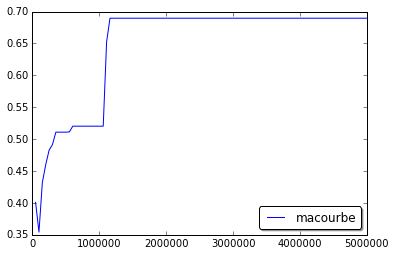

In [371]:
fig = plt.figure()
plt.plot(salaire_de_base_2013, taux_marginal_taxation_totale_h_celibataire, label = "macourbe")
plt.legend(loc = 4, shadow=True, fancybox=True)
plt.xlim([0,salaire_maximal])

### I.2. Nouveau projet: Taxe Exceptionelle de Solidarité sur les Hautes Rémunérations (TEHR)

Le 29 décembre 2013, la loi des finances 2014 est votée par le conseil constitutionnel. Suite à l'implémentation de cette loi, l'article 15 instaure une "Taxe Exeptionnelle de Solidarité sur les Hautes Rémunérations (TEHR)", qui prévoit de taxer à 50% la part des rémunérations supérieure à 1 Million €. Dès lors, les entreprises rémunérant certains employés au delà de 1 million d'euros doivent s'acquitter l'année suivante d'une taxe à 50% sur la part des rémunérations supérieures à 1 million d'euros.

Si le taux marginal de cette taxe n'est pas directement égale à 75% sur les rémunérations supérieurs à 1 millions d'Euros, cummulée avec l'ensemble du système fiscal déjà en place, la TEHR élève effectivement le taux marginal sur les rémunérations supérieurs à 1 millions d'euros à 75%.

D'abord nous allons calculer le taux marginal de l'imposition totale sur le revenu, en prenant soin d'inclure dans l'imposition totale la Taxe Exceptionelle de Solidarité sur les Hautes Rémunérations (TEHR). Ainsi nous pourrons vérifier si le taux marginale de l'imposition totale pour les revenus supérieurs à 1 Million d'Euros correspond à 75%.

In [372]:
def homme_celibataire_tehr(salaire_minimal = 0, nombre_enfants = 0, number_of_year = 4 , salaire_maximal = 5000000):
    simulation = tax_benefit_system.new_scenario().init_single_entity(
        axes = [
            dict(
                count = 100,
                min = salaire_minimal * number_of_year,
                max = salaire_maximal * number_of_year,
                name = 'salaire_de_base',
                ),
            ],
        period = '2010:{}'.format(number_of_year),
        parent1 = dict(
            birth = date(1980, 1, 1),
#            salaire_de_base = {"2013": salaire_maximal, "2014": salaire_maximal}
            ),
        menage = dict(
            loyer = 1000 * 3,
            so = 4,
            ),
        ).new_simulation(debug = True)
    return simulation

In [373]:
tehr_h_celibataire = homme_celibataire_tehr().calculate('tehr', '2013')
print tehr_h_celibataire

[      -0.         -0.         -0.         -0.         -0.         -0.
       -0.         -0.         -0.         -0.         -0.         -0.
       -0.         -0.         -0.         -0.         -0.         -0.
       -0.         -0.      -5050.47   -30302.94   -55555.62   -80808.12
  -106060.69  -131313.19  -156565.69  -181818.19  -207070.69  -232323.25
  -257575.75  -282828.31  -308080.81  -333333.31  -358585.81  -383838.31
  -409090.81  -434343.31  -459595.81  -484848.44  -510100.94  -535353.44
  -560605.88  -585858.75  -611111.25  -636363.75  -661616.25  -686868.75
  -712121.38  -737373.88  -762626.38  -787878.88  -813131.38  -838383.88
  -863636.38  -888888.88  -914141.38  -939394.    -964646.5   -989899.
 -1015151.5  -1040404.   -1065656.62 -1090909.12 -1116161.62 -1141414.12
 -1166666.62 -1191919.12 -1217171.62 -1242424.12 -1267676.62 -1292929.12
 -1318181.62 -1343434.12 -1368686.62 -1393939.12 -1419191.62 -1444444.38
 -1469696.88 -1494949.38 -1520201.88 -1545454.38 -1570706.8

In [374]:
taux_marginal_tehr_h_celibataire = (tehr_h_celibataire[1:]- tehr_h_celibataire[:-1]) / (salbrut_2012[1:] - salbrut_2012[:-1])
print taux_marginal_tehr_h_celibataire

[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.  -0.1 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5]


Taux marginal conforme à nos attentes

In [375]:
revdisp_h_celibataire_tehr = homme_celibataire_tehr().calculate('revdisp','2013') 
print revdisp_h_celibataire_tehr

[    6250.64    36507.68    69120.52    97807.57   125082.55   151207.56
   176884.09   201584.03   226283.98   250984.     275683.97   300359.56
   324584.5    348809.56   373034.53   397259.56   421484.53   445709.47
   469934.47   494159.38   518384.5    542609.5    566834.62   591059.56
   615284.56   639509.56   663734.44   687959.44   712184.44   736409.62
   760634.5    784859.5    809084.5    833309.44   857534.44   881759.38
   905984.38   930209.38   954434.38   978659.44  1002884.38  1027109.38
  1051334.25  1075559.75  1099784.5   1124009.62  1148234.75  1172459.5
  1196684.62  1220909.62  1245134.62  1269359.5   1293584.5   1317809.5
  1342034.5   1366259.5   1390484.5   1414709.62  1438934.5   1463159.5
  1487384.5   1511609.5   1535834.62  1560059.5   1584284.62  1608509.5
  1632734.5   1656959.5   1681184.5   1705409.5   1729634.38  1753859.38
  1778084.38  1802309.38  1826534.38  1850759.38  1874984.25  1899209.38
  1923434.38  1947659.38  1971884.38  1996109.38  20203

In [376]:
salbrut_h_celibataire_tehr = homme_celibataire_tehr().calculate('salbrut','2013') 
print salbrut_h_celibataire_tehr

[       0.      50505.05   101010.1    151515.17   202020.2    252525.23
   303030.34   353535.34   404040.41   454545.41   505050.47   555555.62
   606060.69   656565.69   707070.69   757575.75   808080.81   858585.81
   909090.81   959595.81  1010100.94  1060605.88  1111111.25  1161616.25
  1212121.38  1262626.38  1313131.38  1363636.38  1414141.38  1464646.5
  1515151.5   1565656.62  1616161.62  1666666.62  1717171.62  1767676.62
  1818181.62  1868686.62  1919191.62  1969696.88  2020201.88  2070706.88
  2121211.75  2171717.5   2222222.5   2272727.5   2323232.5   2373737.5
  2424242.75  2474747.75  2525252.75  2575757.75  2626262.75  2676767.75
  2727272.75  2777777.75  2828282.75  2878788.    2929293.    2979798.
  3030303.    3080808.    3131313.25  3181818.25  3232323.25  3282828.25
  3333333.25  3383838.25  3434343.25  3484848.25  3535353.25  3585858.25
  3636363.25  3686868.25  3737373.25  3787878.25  3838383.25  3888888.75
  3939393.75  3989898.75  4040403.75  4090908.75  41414

In [377]:
taxation_totale_h_celibataire_tehr = salbrut_h_celibataire_tehr - revdisp_h_celibataire_tehr
print taxation_totale_h_celibataire_tehr

[   -6250.64    13997.37    31889.58    53707.6     76937.66   101317.67
   126146.25   151951.31   177756.42   203561.41   229366.5    255196.06
   281476.19   307756.12   334036.16   360316.19   386596.28   412876.34
   439156.34   465436.44   491716.44   517996.38   544276.62   570556.69
   596836.81   623116.81   649396.94   675676.94   701956.94   728236.88
   754517.     780797.12   807077.12   833357.19   859637.19   885917.25
   912197.25   938477.25   964757.25   991037.44  1017317.5   1043597.5
  1069877.5   1096157.75  1122438.    1148717.88  1174997.75  1201278.
  1227558.12  1253838.12  1280118.12  1306398.25  1332678.25  1358958.25
  1385238.25  1411518.25  1437798.25  1464078.38  1490358.5   1516638.5
  1542918.5   1569198.5   1595478.62  1621758.75  1648038.62  1674318.75
  1700598.75  1726878.75  1753158.75  1779438.75  1805718.88  1831998.88
  1858278.88  1884558.88  1910838.88  1937118.88  1963399.    1989679.38
  2015959.38  2042239.38  2068519.38  2094799.38  21210

In [378]:
taux_marginal_taxation_totale_h_celibataire_tehr = (taxation_totale_h_celibataire_tehr[1:]- taxation_totale_h_celibataire_tehr[:-1]) / (salbrut_2012[1:] - salbrut_2012[:-1])
print taux_marginal_taxation_totale_h_celibataire_tehr

[ 0.4   0.35  0.43  0.46  0.48  0.49  0.51  0.51  0.51  0.51  0.51  0.52
  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52
  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52
  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52
  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52
  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52
  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52
  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.52
  0.52  0.52  0.52]


On remarque ici que le taux marginal de la taxation totale, sans ajouter la TEHR (qui est prise en charge par l'entreprise), est déjà de 52% pour les revenus supérieurs à 2,5 millions d'euros.

A présent, si l'on suppose que l'élasticité du travail par rapport à la taxation est plus grande pour les entreprises que pour les employés, alors on peut supposer que les entreprises répercuteraient le coût de la TEHR sur le salaire des individus. En effet, si les entreprises sont très élastiques (donc très sensibles au changement de taxation), et si les individus ne sont pas du tout élastiques (donc pas du tout sensibles au changement de taxation), alors les entreprises auront tout intérêt à répercuter le coût de la TEHR sur le salaire de leurs employés. 

Supposons que ce soit le cas, et que les entreprises répercutent le coût de la TEHR sur leurs employés:

In [438]:
taux_marginal_taxation_totale_h_celibataire_tehr = ((taxation_totale_h_celibataire_tehr[1:] - tehr_h_celibataire[1:]) - (taxation_totale_h_celibataire_tehr[:-1] - tehr_h_celibataire[:-1])) / (salbrut_2012[1:] - salbrut_2012[:-1])
print taux_marginal_taxation_totale_h_celibataire_tehr

[ 0.4   0.35  0.43  0.46  0.48  0.49  0.51  0.51  0.51  0.51  0.51  0.52
  0.52  0.52  0.52  0.52  0.52  0.52  0.52  0.62  1.02  1.02  1.02  1.02
  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02
  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02
  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02
  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02
  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02
  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02  1.02
  1.02  1.02  1.02]


En ajoutant la TEHR à la taxation totale des individus, on constate que le taux marginal reste inchangé pour tous les rémunérations inférieures à 1 millions d'euros. En revanche au-delà d'un million d'Euros le taux marginal atteint subitement 102% de leur rémunération.

Un tel niveau de taxation peut paraître allarmant, puisque cela signifierait que la TEHR serait une taxe confiscatoire.

Néanmoins, le fait de simplement ajouter la TEHR à l'imposition générale ne nous donne pas une idée réelle de la réaction des entreprises face à l'implémentation de la TEHR. En effet, si les entreprises choisissaient de répercuter le coût de la TEHR sur ses employés, alors elles le feraient de sorte à maintenir un coût du travail constant.

Faisons abstraction des cotisations patronales, et supposons que le coût du travail corresponde au salaire brut des employés auquel on ajoute la TEHR. Dans ce cas là, le coût du travail correspond à 150% du salaire brut des employés. Si - comme nous l'avons supposé plus haut - les entreprises répercutent le coût de la TEHR sur le salaire brut des employés en abaissant leur salaire brut de 50%, alors ces entreprises font erreur. Par exemple pour un employé gagnant 5.000.000 € brut par an, le coût du travail représente 7.500.000 € avec la TEHR. Si l'entreprise cherchant à répercuter le coût de la TEHR sur son employé, baisse son salaire de 2.500.000 € (donc 50% de son salaire), alors le salaire brut de l'employé devient 2.500.000 €. Ainsi la TEHR correspondrait à présent à 50% x 2.500.000 € = 1.250.000 €, et donc le coût du travail de cet employé pour l'entreprise serait maintenant de 1.250.000 € + 2.500.000 € = 3.750.000 €.

Si l'on suppose que les entreprises cherchent à maintenir constants leurs coût du travail après l'implémentation de la TEHR, alors elles doivent en réalité baisser le salaire des individus non pas de 50%, mais de 33,33%.

En effet, supposons à nouveau un individu dont le salaire brut est de 5.000.000 € avant l'implémentation de la TEHR, et donc que le coût du travail (sans charges patronales) de cet individu corresponde à 5.000.000 €. Une fois que la TEHR entre en vigueur, si l'entreprise baisse le salaire de cet individu de 33,33%, son nouveau salaire brut devient 3.333.333,33 €. Sachant que l'entreprise va devoir payer 50% de TEHR sur ce salaire brut, le coût de travail de cette entreprise correspond désormais à 3.333.333,33 € + 50% x 3.333.333,33 € = 3.333.333,33 € + 1.666.666,67 € = 5.000.000 €.

Cet exemple montre bien que si l'entreprise choisi de répercuter le coût de la TEHR sur les salariés, en cherchant à maintenir constant son coût du travail, elle baisserait les salaires supérieurs à 1 millions d'euros de 33,33%, et non pas de 50%.

Ainsi, puique le taux marginal de la taxation totale sans TEHR représente 52%, si les entreprises choisissaient de répercuter la TEHR sur leurs salariés, alors le taux marginal de la taxation totale sur les salaires supérieurs à 1.000.000 € deviendrait 52% + 33,33% = 85,33%.

Pour avoir une meilleure vue d'ensemble du taux marginal de la taxation totale sans TEHR, traçons un graphe indiquant le taux marginal de taxation totale en fonction du salaire de base.

In [379]:
salaire_de_base_2013 = homme_celibataire_cesthra().calculate('salaire_de_base', '2013')
salaire_de_base_2013 = salaire_de_base_2013[1:]
print salaire_de_base_2013
print len(salaire_de_base_2013)

[   50505.05   101010.1    151515.16   202020.2    252525.25   303030.31
   353535.34   404040.41   454545.47   505050.5    555555.56   606060.62
   656565.69   707070.69   757575.75   808080.81   858585.88   909090.94
   959595.94  1010101.    1060606.    1111111.12  1161616.12  1212121.25
  1262626.25  1313131.38  1363636.38  1414141.38  1464646.5   1515151.5
  1565656.62  1616161.62  1666666.62  1717171.75  1767676.75  1818181.88
  1868686.88  1919191.88  1969697.    2020202.    2070707.12  2121212.
  2171717.25  2222222.25  2272727.25  2323232.25  2373737.25  2424242.5
  2474747.5   2525252.5   2575757.5   2626262.75  2676767.75  2727272.75
  2777777.75  2828282.75  2878788.    2929293.    2979798.    3030303.
  3080808.    3131313.25  3181818.25  3232323.25  3282828.25  3333333.25
  3383838.5   3434343.5   3484848.5   3535353.5   3585858.5   3636363.75
  3686868.75  3737373.75  3787878.75  3838383.75  3888889.    3939394.
  3989899.    4040404.    4090909.    4141414.25  4191919.2

(0, 5000000)

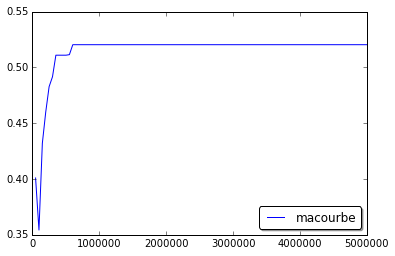

In [380]:
fig = plt.figure()
plt.plot(salaire_de_base_2013, taux_marginal_taxation_totale_h_celibataire_tehr, label = "macourbe")
plt.legend(loc = 4, shadow=True, fancybox=True)
plt.xlim([0,salaire_maximal])

Comme on peut le voir ici, le taux marginal de taxation est croissant jusqu'à 1 million d'euros environ. Si l'on rajoutait la TEHR, prise en charge par l'entrprise, au taux marginal de taxation on obtiendrais un taux marginal de taxation total s'élevant à 102% des salaires imposables supérieurs à 1.000.000 €.
Si en revanche on supposait que les entreprises choisissaient de répercuter le coût de la TEHR sur les employés, alors le taux marginal de taxation sur les rémunérations supérieurs atteindrait 85,33%.

C'est donc un taux qui est nettement supérieur au projet de réforme initial (avec CESRA), qui prévoyait de taxer à 75% les revenus supérieurs à 1.000.000 €. Ainsi, nous pourrions souligner le comportement contradictoire du conseil constitutionnel, qui choisi de rejeter la réforme initiale sous prétexte qu'elle ne tenait pas compte des capacités contributives des ménages, et qui instaure une taxe encore plus forte dans le projet corrigé.

Cependant, il faut tout de même préciser qu'avec le bouclier fiscal modifié par le gouvernement Hollande, la pression fiscale totale sur les contribuables ne peut excéder 75% de leurs revenus. Et par conséquent, avec le bouclier fiscal actuel, il est en réalité plus difficile de déterminer quel projet de réforme est avantageux pour quels ménages. 

Pour y voir plus clair, nous allons à présent déterminer la différence de revenu disponible en fonction des deux réformes, selon le salaire de base des individus.

### I.3. Graphique Différence revenu disponible (entre CESRA/TEHR) / revenu imposable

In [439]:
difference_revenue_disponible_2reformes = revdisp_h_celibataire_tehr - revdisp_2013_cesthra
difference_revenue_disponible_2reformes = difference_revenue_disponible_2reformes[:-1]
print difference_revenue_disponible_2reformes
print len(difference_revenue_disponible_2reformes)

[      0.         0.         0.         0.         0.         0.         0.
       0.         0.         0.         0.         0.         0.         0.
       0.         0.         0.         0.         0.         0.         0.
       0.      6668.75   15218.69   23768.69   32318.69   40868.62
   49418.62   57968.62   66518.69   75068.69   83618.69   92168.69
  100718.62  109268.62  117818.62  126368.62  134918.62  143468.62
  152018.62  160568.62  169118.62  177668.5   186218.75  194768.62
  203318.62  211868.75  220418.62  228968.62  237518.62  246068.62
  254618.62  263168.62  271718.62  280268.62  288818.62  297368.62
  305918.62  314468.62  323018.62  331568.62  340118.62  348668.62
  357218.62  365768.62  374318.62  382868.62  391418.62  399968.62
  408518.62  417068.62  425618.62  434168.62  442718.62  451268.62
  459818.62  468368.5   476918.62  485468.62  494018.62  502568.62
  511118.62  519668.5   528218.5   536768.5   545318.62  553868.75
  562418.75  570968.75  579518.5   

(0, 5000000)

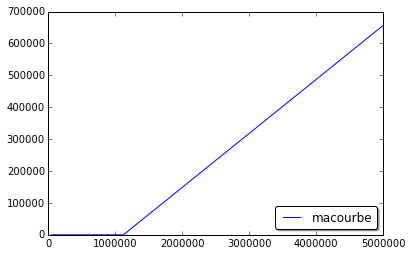

In [440]:
fig = plt.figure()
plt.plot(salaire_de_base_2013, difference_revenue_disponible_2reformes, label = "macourbe")
plt.legend(loc = 4, shadow=True, fancybox=True)
plt.xlim([0,salaire_maximal])

Sans surprise nous constatons que la réforme finale est plus avantageuse pour les revenus excédant le million d'Euros. Mais ce résultat s'explique en grande partie par le fait que nous n'avons pas ajouté la Taxe Exceptionelle de Solidarité sur les Très Hautes Rémunérations (TEHR).

Nous allons à présent supposer que les entreprises impacteraient le coût de la TEHR sur les individus, et nous allons donc ajouter 33,33% au taux marginal de taxation pour le projet retenu par le conseil constitutionnel.

In [462]:
revdisp_2013_tehr_repercute = (1-0.8533)*salaire_de_base_2013
print revdisp_2013_tehr_repercute
print len(revdisp_2013_tehr_repercute)

[   7409.09082    14818.181641   22227.273438   29636.363281   37045.453125
   44454.546875   51863.632812   59272.726562   66681.820312   74090.90625
   81500.         88909.09375    96318.179688  103727.265625  111136.359375
  118545.453125  125954.546875  133363.640625  140772.71875   148181.8125
  155590.890625  163000.        170409.078125  177818.1875    185227.265625
  192636.359375  200045.453125  207454.53125   214863.640625  222272.71875
  229681.8125    237090.90625   244499.984375  251909.09375   259318.171875
  266727.28125   274136.34375   281545.4375    288954.53125   296363.625
  303772.71875   311181.78125   318590.90625   326000.        333409.0625
  340818.15625   348227.25      355636.375     363045.4375    370454.53125
  377863.625     385272.71875   392681.8125    400090.90625   407499.96875
  414909.0625    422318.1875    429727.28125   437136.34375   444545.4375
  451954.53125   459363.625     466772.71875   474181.8125    481590.875
  488999.96875   496409.0937

In [465]:
difference_revenue_disponible_2reformes_tehr_repercute = revdisp_2013_tehr_repercute - revdisp_2013_cesthra[1:]
print difference_revenue_disponible_2reformes_tehr_repercute
print len(difference_revenue_disponible_2reformes_tehr_repercute)

[  -29098.589844   -54302.34375    -75580.296875   -95446.1875
  -114162.109375  -132429.546875  -149720.40625   -167011.25      -184302.1875
  -201593.0625    -218859.5625    -235675.40625   -252491.375     -269307.25
  -286123.1875    -302939.0625    -319754.9375    -336570.8125
  -353386.65625   -370202.6875    -387018.625     -397165.875     -405431.8125
  -413697.6875    -421963.625     -430229.4375    -438495.375
  -446761.28125   -455027.3125    -463293.09375   -471559.        -479824.90625
  -488090.8125    -496356.71875   -504622.5625    -512888.46875
  -521154.40625   -529420.3125    -537686.25      -545952.125     -554218.
  -562484.        -570750.125     -579015.875     -587281.9375    -595547.875
  -603813.625     -612079.625     -620345.5625    -628611.5       -636877.25
  -645143.125     -653409.0625    -661675.        -669940.875     -678206.8125
  -686472.8125    -694738.625     -703004.5       -711270.4375    -719536.375
  -727802.375     -736068.125     -744334.1875

(0, 5000000)

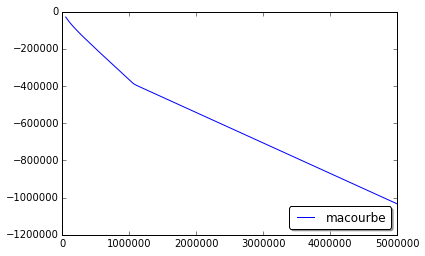

In [466]:
fig = plt.figure()
plt.plot(salaire_de_base_2013, difference_revenue_disponible_2reformes_tehr_repercute, label = "macourbe")
plt.legend(loc = 4, shadow=True, fancybox=True)
plt.xlim([0,salaire_maximal])

Sur ce graphique les salaires inférieurs à 1.000.000 € ne sont pas à prendre en compte parce qu'ils soumis à TEHR de 33%, alors qu'en réalité ils ne le seraient pas. Mais comme nous l'avons vu sur le graphe précédent il n'y a pas de réél changement entre les deux réformes pour les salaires inférieurs à 1.000.000 €.

Pour les salaires supérieurs à 1.000.000 €, on constate que la réforme initiale (CESRA) était plus avantageuse pour les hautes rémunérations que la nouvelle réforme (TEHR).

Ainsi pour conclure cette partie, nous pouvons dire que selon comment les entreprises décident de réagir à la TEHR, la première ou la seconde réforme peuvent-être avantageuses pour les employés.

En effet, si l'on suppose que les entreprises répercuterons l'intégralité des coûts de la TEHR sur leurs employés, alors la première réforme aurait été plus avantageuse pour eux. Si en revanche les entreprises acceptent de payer l'intégralité de la TEHR, alors l'ancienne réforme aurait été plus avantageuse pour les employés.

Dans les faits, il est très probable que les coûts de la TEHR soient partagés par l'entreprise et les employés rémunérés à plus de 1.000.000 €. Mais pour savoir plus précisemment comment ces coûts seraient partagés il faudrait connaître l'élasticité des entreprises et de leurs employés.

## II. Différence d'imposition entre les deux réformes dans le cadre du quotient famillial, pour un couple marié avec des revenus disparates

Quelle réforme avantage le plus les couples mariés?

### II.1. Nouveau projet: Taxe Exceptionelle de Solidarité sur les Hautes Rémunérations (TEHR)

In [15]:
salaire_maximal = 5000000

In [16]:
def couple_sans_enfant_tehr(nombre_enfants = 0, year = 2015):
    enfant = [dict(
        birth = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    simulation = tax_benefit_system.new_scenario().init_single_entity(
        axes = [
            dict(
                count = 100,
                min = 0,
                max = salaire_maximal * 3,
                name = 'sal',
                ),
            ],
        period = "{}:3".format(year-2),
        parent1 = dict(
            birth = date(1980, 1, 1),
            statmarit = 1
            ),
        parent2 = dict(
            birth = date(1980, 1, 1),
            sal = 0,
            statmarit = 1
            ),
        menage = dict(
            loyer = 1000 * 3,
            so = 4,
            ),
        ).new_simulation(debug = True)
    return simulation

In [18]:
revdisp_couple_tehr = couple_sans_enfant_tehr().calculate('revdisp', '2014')
print len(revdisp_couple_tehr)

100


In [20]:
salaire_imposable_couple_2014 = couple_sans_enfant_tehr().calculate('sal', '2014')[::2]
print salaire_imposable_couple_2014
print len(salaire_imposable_couple_2014)

[       0.      50505.05   101010.1    151515.16   202020.2    252525.25
   303030.31   353535.34   404040.41   454545.47   505050.5    555555.56
   606060.62   656565.69   707070.69   757575.75   808080.81   858585.81
   909090.94   959596.    1010101.    1060606.12  1111111.12  1161616.12
  1212121.25  1262626.25  1313131.38  1363636.38  1414141.38  1464646.5
  1515151.5   1565656.5   1616161.62  1666666.62  1717171.62  1767676.88
  1818181.88  1868686.88  1919192.    1969697.    2020202.    2070707.
  2121212.25  2171717.25  2222222.25  2272727.25  2323232.25  2373737.25
  2424242.5   2474747.5   2525252.5   2575757.5   2626262.75  2676767.75
  2727272.75  2777777.75  2828282.75  2878788.    2929293.    2979798.
  3030303.    3080808.    3131313.    3181818.25  3232323.25  3282828.25
  3333333.25  3383838.25  3434343.25  3484848.25  3535353.75  3585858.75
  3636363.75  3686868.75  3737373.75  3787878.75  3838384.    3888889.
  3939394.    3989899.    4040404.    4090909.    4141414.

In [21]:
taxation_totale_couple_tehr = salaire_imposable_couple_2014 - revdisp_couple_tehr
print taxation_totale_couple_tehr
print len(taxation_totale_couple_tehr)

[   -9037.46     3650.37    15995.05    30547.77    50804.95    71512.03
    92219.09   114487.69   137214.97   159942.25   182669.5    206700.56
   230943.     255185.41   279427.81   303670.25   327912.66   352155.06
   376397.56   400640.     424882.38   449609.88   474357.38   499104.81
   523852.31   548599.75   573347.31   598094.75   622842.19   647589.69
   672337.12   697084.56   721832.06   746579.56   771327.     796074.56
   820822.     845569.5    870317.     895064.5    919811.88   944559.25
   969307.     994054.38  1018801.75  1043549.25  1068296.75  1093044.12
  1117791.75  1142539.12  1167286.62  1192034.    1216781.62  1241529.12
  1266276.5   1291024.    1315771.38  1340519.    1365266.5   1390013.88
  1414761.38  1439508.75  1464256.25  1489003.88  1513751.25  1538498.75
  1563246.25  1587993.62  1612741.12  1637488.5   1662236.25  1686983.75
  1711731.12  1736478.62  1761226.12  1785973.5   1810721.12  1835468.5
  1860216.    1884963.5   1909711.    1934458.5   19

In [22]:
tehr_couple = couple_sans_enfant_tehr().calculate('tehr', '2013')[::2]
print tehr_couple
print len(tehr_couple)

[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
100


In [24]:
taux_marginal_taxation_totale_couple_bla =  ((taxation_totale_couple_tehr[1:] - tehr_couple[1:]) - (taxation_totale_couple_tehr[:-1] - tehr_couple[:-1])) / (salaire_imposable_couple_2014[1:] - salaire_imposable_couple_2014[:-1] ) 
taux_marginal_taxation_totale_couple_bla

array([ 0.25,  0.24,  0.29,  0.4 ,  0.41,  0.41,  0.44,  0.45,  0.45,
        0.45,  0.48,  0.48,  0.48,  0.48,  0.48,  0.48,  0.48,  0.48,
        0.48,  0.48,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,
        0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,
        0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,
        0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,
        0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,
        0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,
        0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,
        0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,
        0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49,  0.49], dtype=float32)

In [26]:
taux_marginal_taxation_totale_couple =  (taxation_totale_couple_tehr[1:] - taxation_totale_couple_tehr[:-1]) / (salaire_imposable_couple_2014[1:] - salaire_imposable_couple_2014[:-1] ) 
print taux_marginal_taxation_totale_couple
print len(taux_marginal_taxation_totale_couple)

[ 0.25  0.24  0.29  0.4   0.41  0.41  0.44  0.45  0.45  0.45  0.48  0.48
  0.48  0.48  0.48  0.48  0.48  0.48  0.48  0.48  0.49  0.49  0.49  0.49
  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49
  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49
  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49
  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49
  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49
  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49  0.49
  0.49  0.49  0.49]
99


In [ ]:
salaire_imposable_2014 = salaire_imposable_2014[1:]
print salaire_imposable_2014
print len(salaire_imposable_2014)

In [ ]:
fig = plt.figure()
plt.plot(salaire_imposable_2014, taux_marginal_taxation_totale_couple, label = "macourbe")
plt.legend(loc = 4, shadow=True, fancybox=True)
plt.xlim([0,salaire_maximal])

### II.2. Projet initial: Contribution Exceptionnelle de Solidarité sur les trés Hauts Revenus d'Activité (CESRA)

In [342]:
def couple_sans_enfant_cesthra(nombre_enfants = 0, year = 2015):
    enfant = [dict(
        birth = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    simulation = tax_benefit_cesthra.new_scenario().init_single_entity(
        axes = [
            dict(
                count = 100,
                min = 0,
                max = salaire_maximal * 3,
                name = 'sal',
                ),
            ],
        period = "{}:3".format(year-2),
        parent1 = dict(
            birth = date(1980, 1, 1),
            statmarit = 1
            ),
        parent2 = dict(
            birth = date(1980, 1, 1),
            sal = 0,
            statmarit = 1
            ),
        menage = dict(
            loyer = 1000 * 3,
            so = 4,
            ),
        ).new_simulation(debug = True)
    return simulation

In [343]:
cesthra = couple_sans_enfant_cesthra().calculate('cesthra', '2014')
cesthra

array([      0.  ,       0.  ,       0.  ,       0.  ,       0.  ,
             0.  ,       0.  ,       0.  ,       0.  ,       0.  ,
             0.  ,       0.  ,       0.  ,       0.  ,       0.  ,
             0.  ,       0.  ,       0.  ,       0.  ,       0.  ,
          1818.18,   10909.1 ,   20000.  ,   29090.9 ,   38181.82,
         47272.73,   56363.65,   65454.55,   74545.45,   83636.37,
         92727.27,  101818.17,  110909.09,  119999.99,  129090.89,
        138181.84,  147272.73,  156363.64,  165454.56,  174545.45,
        183636.36,  192727.27,  201818.2 ,  210909.11,  220000.  ,
        229090.91,  238181.81,  247272.7 ,  256363.66,  265454.56,
        274545.44,  283636.34,  292727.28,  301818.19,  310909.09,
        320000.  ,  329090.91,  338181.84,  347272.75,  356363.62,
        365454.53,  374545.44,  383636.34,  392727.28,  401818.19,
        410909.09,  420000.  ,  429090.88,  438181.78,  447272.69,
        456363.69,  465454.56,  474545.47,  483636.38,  492727

In [344]:
revdisp_couple = couple_sans_enfant_cesthra().calculate('revdisp', '2014')
print len(revdisp_h_couple)

100


In [301]:
salaire_imposable_2014 = couple_sans_enfant_cesthra().calculate('sal', '2014')[::2]
print salaire_imposable_2014
print len(salaire_imposable_2014)

[       0.      50505.05   101010.1    151515.16   202020.2    252525.25
   303030.31   353535.34   404040.41   454545.47   505050.5    555555.56
   606060.62   656565.69   707070.69   757575.75   808080.81   858585.81
   909090.94   959596.    1010101.    1060606.12  1111111.12  1161616.12
  1212121.25  1262626.25  1313131.38  1363636.38  1414141.38  1464646.5
  1515151.5   1565656.5   1616161.62  1666666.62  1717171.62  1767676.88
  1818181.88  1868686.88  1919192.    1969697.    2020202.    2070707.
  2121212.25  2171717.25  2222222.25  2272727.25  2323232.25  2373737.25
  2424242.5   2474747.5   2525252.5   2575757.5   2626262.75  2676767.75
  2727272.75  2777777.75  2828282.75  2878788.    2929293.    2979798.
  3030303.    3080808.    3131313.    3181818.25  3232323.25  3282828.25
  3333333.25  3383838.25  3434343.25  3484848.25  3535353.75  3585858.75
  3636363.75  3686868.75  3737373.75  3787878.75  3838384.    3888889.
  3939394.    3989899.    4040404.    4090909.    4141414.

In [333]:
taxation_totale_couple_cesthra = salbrut_h_couple - revdisp_couple
print taxation_totale_couple_cesthra
print len(taxation_totale_couple_cesthra)

[   -9037.46   -46854.68   -85015.05  -120967.39  -151215.25  -181013.22
  -210811.22  -239047.66  -266825.44  -294603.22  -322381.    -348855.
  -375117.62  -401380.28  -427642.88  -453905.5   -480168.16  -506430.75
  -532693.38  -558956.    -583400.44  -600087.12  -616753.75  -633420.44
  -650087.12  -666753.75  -683420.44  -700087.06  -716753.75  -733420.44
  -750087.12  -766753.75  -783420.5   -800087.06  -816753.75  -833420.5
  -850087.12  -866753.75  -883420.44  -900087.12  -916753.75  -933420.38
  -950087.12  -966753.75  -983420.5  -1000087.12 -1016753.75 -1033420.38
 -1050087.12 -1066753.75 -1083420.5  -1100087.12 -1116753.88 -1133420.5
 -1150087.12 -1166753.75 -1183420.5  -1200087.12 -1216753.75 -1233420.5
 -1250087.12 -1266753.75 -1283420.38 -1300087.12 -1316753.75 -1333420.38
 -1350087.   -1366753.75 -1383420.38 -1400087.   -1416753.75 -1433420.5
 -1450087.25 -1466753.75 -1483420.25 -1500087.   -1516753.75 -1533420.5
 -1550087.   -1566753.75 -1583420.5  -1600087.   -1616753.

In [325]:
salaire_imposable_couple_2014 = couple_sans_enfant_tehr().calculate('sal', '2014')[::2]
print salaire_imposable_couple_2014
print len(salaire_imposable_couple_2014)

[       0.      50505.05   101010.1    151515.16   202020.2    252525.25
   303030.31   353535.34   404040.41   454545.47   505050.5    555555.56
   606060.62   656565.69   707070.69   757575.75   808080.81   858585.81
   909090.94   959596.    1010101.    1060606.12  1111111.12  1161616.12
  1212121.25  1262626.25  1313131.38  1363636.38  1414141.38  1464646.5
  1515151.5   1565656.5   1616161.62  1666666.62  1717171.62  1767676.88
  1818181.88  1868686.88  1919192.    1969697.    2020202.    2070707.
  2121212.25  2171717.25  2222222.25  2272727.25  2323232.25  2373737.25
  2424242.5   2474747.5   2525252.5   2575757.5   2626262.75  2676767.75
  2727272.75  2777777.75  2828282.75  2878788.    2929293.    2979798.
  3030303.    3080808.    3131313.    3181818.25  3232323.25  3282828.25
  3333333.25  3383838.25  3434343.25  3484848.25  3535353.75  3585858.75
  3636363.75  3686868.75  3737373.75  3787878.75  3838384.    3888889.
  3939394.    3989899.    4040404.    4090909.    4141414.

In [345]:
taux_marginal_taxation_totale_couple_cesthra =  ((taxation_totale_couple_cesthra[1:] - cesthra[1:]) - (taxation_totale_couple_cesthra[:-1] - cesthra[:-1])) / (salaire_imposable_couple_2014[1:] - salaire_imposable_couple_2014[:-1] ) 
print taux_marginal_taxation_totale_couple_cesthra
print len(taux_marginal_taxation_totale_couple_cesthra)

[-0.75 -0.76 -0.71 -0.6  -0.59 -0.59 -0.56 -0.55 -0.55 -0.55 -0.52 -0.52
 -0.52 -0.52 -0.52 -0.52 -0.52 -0.52 -0.52 -0.52 -0.51 -0.51 -0.51 -0.51
 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51
 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51
 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51
 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51
 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51
 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51 -0.51
 -0.51 -0.51 -0.51]
99


In [346]:
taux_marginal_taxation_totale_couple_cesthra_bla =  (taxation_totale_couple_cesthra[1:] - taxation_totale_couple_cesthra[:-1]) / (salaire_imposable_couple_2014[1:] - salaire_imposable_couple_2014[:-1] ) 
taux_marginal_taxation_totale_couple_cesthra_bla


array([-0.75, -0.76, -0.71, -0.6 , -0.59, -0.59, -0.56, -0.55, -0.55,
       -0.55, -0.52, -0.52, -0.52, -0.52, -0.52, -0.52, -0.52, -0.52,
       -0.52, -0.48, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33,
       -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33,
       -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33,
       -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33,
       -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33,
       -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33,
       -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33,
       -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33,
       -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33], dtype=float32)

In [331]:
salaire_imposable_couple_2014 = couple_sans_enfant_tehr().calculate('sal', '2014')[::2]
salaire_imposable_couple_2014 = salaire_imposable_couple_2014[1:]
print salaire_imposable_couple_2014
print len(salaire_imposable_couple_2014)

[   50505.05   101010.1    151515.16   202020.2    252525.25   303030.31
   353535.34   404040.41   454545.47   505050.5    555555.56   606060.62
   656565.69   707070.69   757575.75   808080.81   858585.81   909090.94
   959596.    1010101.    1060606.12  1111111.12  1161616.12  1212121.25
  1262626.25  1313131.38  1363636.38  1414141.38  1464646.5   1515151.5
  1565656.5   1616161.62  1666666.62  1717171.62  1767676.88  1818181.88
  1868686.88  1919192.    1969697.    2020202.    2070707.    2121212.25
  2171717.25  2222222.25  2272727.25  2323232.25  2373737.25  2424242.5
  2474747.5   2525252.5   2575757.5   2626262.75  2676767.75  2727272.75
  2777777.75  2828282.75  2878788.    2929293.    2979798.    3030303.
  3080808.    3131313.    3181818.25  3232323.25  3282828.25  3333333.25
  3383838.25  3434343.25  3484848.25  3535353.75  3585858.75  3636363.75
  3686868.75  3737373.75  3787878.75  3838384.    3888889.    3939394.
  3989899.    4040404.    4090909.    4141414.    4191919

(0, 5000000)

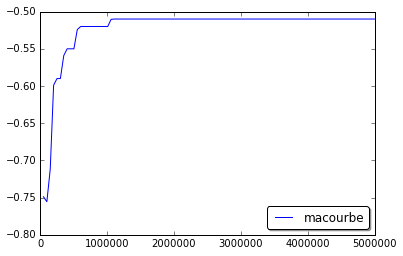

In [332]:
fig = plt.figure()
plt.plot(salaire_imposable_couple_2014, taux_marginal_taxation_totale_couple_cesthra, label = "macourbe")
plt.legend(loc = 4, shadow=True, fancybox=True)
plt.xlim([0,salaire_maximal])

### II.3. Différence d'imposition entre pour un couple entre CESRA et TEHR

In [365]:
taxation_totale_couple_cesthra
print taxation_totale_couple_cesthra
print len(taxation_totale_couple_cesthra)

[   -9037.46   -46854.68   -85015.05  -120967.39  -151215.25  -181013.22
  -210811.22  -239047.66  -266825.44  -294603.22  -322381.    -348855.
  -375117.62  -401380.28  -427642.88  -453905.5   -480168.16  -506430.75
  -532693.38  -558956.    -583400.44  -600087.12  -616753.75  -633420.44
  -650087.12  -666753.75  -683420.44  -700087.06  -716753.75  -733420.44
  -750087.12  -766753.75  -783420.5   -800087.06  -816753.75  -833420.5
  -850087.12  -866753.75  -883420.44  -900087.12  -916753.75  -933420.38
  -950087.12  -966753.75  -983420.5  -1000087.12 -1016753.75 -1033420.38
 -1050087.12 -1066753.75 -1083420.5  -1100087.12 -1116753.88 -1133420.5
 -1150087.12 -1166753.75 -1183420.5  -1200087.12 -1216753.75 -1233420.5
 -1250087.12 -1266753.75 -1283420.38 -1300087.12 -1316753.75 -1333420.38
 -1350087.   -1366753.75 -1383420.38 -1400087.   -1416753.75 -1433420.5
 -1450087.25 -1466753.75 -1483420.25 -1500087.   -1516753.75 -1533420.5
 -1550087.   -1566753.75 -1583420.5  -1600087.   -1616753.

In [366]:
taxation_totale_couple_tehr
print taxation_totale_couple_tehr
print len(taxation_totale_couple_tehr)

[   -9037.46     3650.37    15995.05    30547.77    50804.95    71512.03
    92219.09   114487.69   137214.97   159942.25   182669.5    206700.56
   230943.     255185.41   279427.81   303670.25   327912.66   352155.06
   376397.56   400640.     424882.38   449609.88   474357.38   499104.81
   523852.31   548599.75   573347.31   598094.75   622842.19   647589.69
   672337.12   697084.56   721832.06   746579.56   771327.     796074.56
   820822.     845569.5    870317.     895064.5    919811.88   944559.25
   969307.     994054.38  1018801.75  1043549.25  1068296.75  1093044.12
  1117791.75  1142539.12  1167286.62  1192034.    1216781.62  1241529.12
  1266276.5   1291024.    1315771.38  1340519.    1365266.5   1390013.88
  1414761.38  1439508.75  1464256.25  1489003.88  1513751.25  1538498.75
  1563246.25  1587993.62  1612741.12  1637488.5   1662236.25  1686983.75
  1711731.12  1736478.62  1761226.12  1785973.5   1810721.12  1835468.5
  1860216.    1884963.5   1909711.    1934458.5   19

In [389]:
Difference_taxation_totale_couple = taxation_totale_couple_cesthra + taxation_totale_couple_tehr
Difference_taxation_totale_couple

array([ -18074.91,  -43204.32,  -69019.99,  -90419.62, -100410.3 ,
       -109501.19, -118592.12, -124559.97, -129610.47, -134660.97,
       -139711.5 , -142154.44, -144174.62, -146194.88, -148215.06,
       -150235.25, -152255.5 , -154275.69, -156295.81, -158316.  ,
       -158518.06, -150477.25, -142396.38, -134315.62, -126234.81,
       -118154.  , -110073.12, -101992.31,  -93911.56,  -85830.75,
        -77750.  ,  -69669.19,  -61588.44,  -53507.5 ,  -45426.75,
        -37345.94,  -29265.12,  -21184.25,  -13103.44,   -5022.62,
          3058.12,   11138.88,   19219.88,   27300.62,   35381.25,
         43462.12,   51543.  ,   59623.75,   67704.62,   75785.38,
         83866.12,   91946.88,  100027.75,  108108.62,  116189.38,
        124270.25,  132350.88,  140431.88,  148512.75,  156593.38,
        164674.25,  172755.  ,  180835.88,  188916.75,  196997.5 ,
        205078.38,  213159.25,  221239.88,  229320.75,  237401.5 ,
        245482.5 ,  253563.25,  261643.88,  269724.88,  277805

In [390]:
Difference_taux_marginal_couple_2_reformes =  (Difference_taxation_totale_couple[1:] - Difference_taxation_totale_couple[:-1]) / (salaire_imposable_couple_2014[1:] - salaire_imposable_couple_2014[:-1] ) 
print Difference_taux_marginal_couple_2_reformes
print len(Difference_taux_marginal_couple_2_reformes)

[-0.5  -0.51 -0.42 -0.2  -0.18 -0.18 -0.12 -0.1  -0.1  -0.1  -0.05 -0.04
 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.04 -0.    0.16  0.16  0.16  0.16
  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
  0.16  0.16  0.16]
99


In [392]:
salaire_imposable_couple_2014 = couple_sans_enfant_tehr().calculate('sal', '2014')[::2]
salaire_imposable_couple_2014 = salaire_imposable_couple_2014[1:]
print salaire_imposable_2014
print len(salaire_imposable_2014)

[   50505.05   101010.1    151515.16   202020.2    252525.25   303030.31
   353535.34   404040.41   454545.47   505050.5    555555.56   606060.62
   656565.69   707070.69   757575.75   808080.81   858585.81   909090.94
   959596.    1010101.    1060606.12  1111111.12  1161616.12  1212121.25
  1262626.25  1313131.38  1363636.38  1414141.38  1464646.5   1515151.5
  1565656.5   1616161.62  1666666.62  1717171.62  1767676.88  1818181.88
  1868686.88  1919192.    1969697.    2020202.    2070707.    2121212.25
  2171717.25  2222222.25  2272727.25  2323232.25  2373737.25  2424242.5
  2474747.5   2525252.5   2575757.5   2626262.75  2676767.75  2727272.75
  2777777.75  2828282.75  2878788.    2929293.    2979798.    3030303.
  3080808.    3131313.    3181818.25  3232323.25  3282828.25  3333333.25
  3383838.25  3434343.25  3484848.25  3535353.75  3585858.75  3636363.75
  3686868.75  3737373.75  3787878.75  3838384.    3888889.    3939394.
  3989899.    4040404.    4090909.    4141414.    4191919

(0, 5000000)

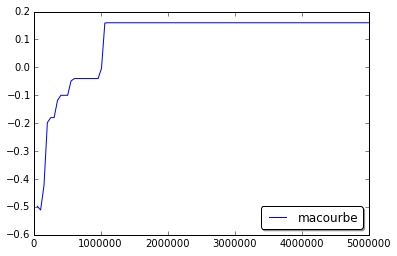

In [393]:
fig = plt.figure()
plt.plot(salaire_imposable_couple_2014, Difference_taux_marginal_couple_2_reformes, label = "macourbe")
plt.legend(loc = 4, shadow=True, fancybox=True)
plt.xlim([0,salaire_maximal])

## III. Incitation à se marrier sous chacune des deux réformes

On a vu qu'il y a une incitation à se marrier si l'on compare les résultats en I et II

### III.1. Projet initial: Contribution Exceptionnelle de Solidarité sur les trés Hauts Revenus d'Activité (CESRA)

Définir Couple non-marié

In [396]:
def couple_celibataire_cesthra(nombre_enfants = 0, year = 2015):
    enfant = [dict(
        birth = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    simulation = tax_benefit_cesthra.new_scenario().init_single_entity(
        axes = [
            dict(
                count = 100,
                min = 0,
                max = salaire_maximal * 3,
                name = 'sal',
                ),
            ],
        period = "{}:3".format(year-2),
        parent1 = dict(
            birth = date(1980, 1, 1),
            statmarit = 2
            ),
        parent2 = dict(
            birth = date(1980, 1, 1),
            sal = 0,
            statmarit = 2
            ),
        menage = dict(
            loyer = 1000 * 3,
            so = 4,
            ),
        ).new_simulation(debug = True)
    return simulation

Déterminer revenu disponible

In [414]:
revdisp_celibataires_cesthra = couple_celibataire_cesthra().calculate('revdisp','2014')
print revdisp_celibataires_cesthra
print len(revdisp_celibataires_cesthra)

[    9037.46    42507.68    77269.15   107885.49   136134.53   163912.31
   190462.09   216724.72   242987.36   269250.     295512.59   321340.62
   347098.25   372855.81   398613.38   424370.94   450128.53   475886.06
   501643.69   527401.25   551340.62   568007.38   584674.     601340.69
   618007.31   634673.94   651340.69   668007.31   684674.     701340.62
   718007.31   734673.94   751340.62   768007.25   784673.94   801340.62
   818007.31   834674.     851340.62   868007.25   884674.     901340.62
   918007.38   934674.     951340.62   968007.38   984674.    1001340.62
  1018007.25  1034674.    1051340.5   1068007.25  1084674.12  1101340.75
  1118007.38  1134674.    1151340.75  1168007.38  1184674.    1201340.75
  1218007.38  1234674.    1251340.62  1268007.38  1284674.    1301340.62
  1318007.25  1334674.    1351340.62  1368007.25  1384674.    1401340.75
  1418007.5   1434674.    1451340.75  1468007.25  1484674.    1501340.75
  1518007.25  1534674.    1551340.5   1568007.25  1

In [407]:
salaire_imposable_couple_2014 = couple_celibataire_cesthra().calculate('sal','2014')
salaire_imposable_couple_2014 = salaire_imposable_couple_2014[::2]
print salaire_imposable_couple_2014
print len(salaire_imposable_couple_2014)

[       0.      50505.05   101010.1    151515.16   202020.2    252525.25
   303030.31   353535.34   404040.41   454545.47   505050.5    555555.56
   606060.62   656565.69   707070.69   757575.75   808080.81   858585.81
   909090.94   959596.    1010101.    1060606.12  1111111.12  1161616.12
  1212121.25  1262626.25  1313131.38  1363636.38  1414141.38  1464646.5
  1515151.5   1565656.5   1616161.62  1666666.62  1717171.62  1767676.88
  1818181.88  1868686.88  1919192.    1969697.    2020202.    2070707.
  2121212.25  2171717.25  2222222.25  2272727.25  2323232.25  2373737.25
  2424242.5   2474747.5   2525252.5   2575757.5   2626262.75  2676767.75
  2727272.75  2777777.75  2828282.75  2878788.    2929293.    2979798.
  3030303.    3080808.    3131313.    3181818.25  3232323.25  3282828.25
  3333333.25  3383838.25  3434343.25  3484848.25  3535353.75  3585858.75
  3636363.75  3686868.75  3737373.75  3787878.75  3838384.    3888889.
  3939394.    3989899.    4040404.    4090909.    4141414.

(0, 5000000)

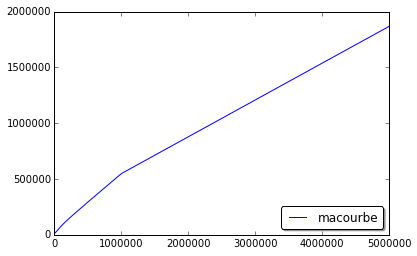

In [412]:
fig = plt.figure()
plt.plot(salaire_imposable_couple_2014, revdisp_celibataires_cesthra, label = "macourbe")
plt.legend(loc = 4, shadow=True, fancybox=True)
plt.xlim([0,salaire_maximal])

Définir Couple marié

In [413]:
def couple_marie_cesthra(nombre_enfants = 0, year = 2015):
    enfant = [dict(
        birth = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    simulation = tax_benefit_cesthra.new_scenario().init_single_entity(
        axes = [
            dict(
                count = 100,
                min = 0,
                max = salaire_maximal * 3,
                name = 'sal',
                ),
            ],
        period = "{}:3".format(year-2),
        parent1 = dict(
            birth = date(1980, 1, 1),
            statmarit = 1
            ),
        parent2 = dict(
            birth = date(1980, 1, 1),
            sal = 0,
            statmarit = 1
            ),
        menage = dict(
            loyer = 1000 * 3,
            so = 4,
            ),
        ).new_simulation(debug = True)
    return simulation

Déterminer revenu disponible

In [415]:
revdisp_maries_cesthra = couple_marie_cesthra().calculate('revdisp','2014')
print revdisp_maries_cesthra
print len(cesthra_celibataires)

[    9037.46    46854.68    85015.05   120967.39   151215.25   181013.22
   210811.22   239047.66   266825.44   294603.22   322381.     348855.
   375117.62   401380.28   427642.88   453905.5    480168.16   506430.75
   532693.38   558956.     583400.44   600087.12   616753.75   633420.44
   650087.12   666753.75   683420.44   700087.06   716753.75   733420.44
   750087.12   766753.75   783420.5    800087.06   816753.75   833420.5
   850087.12   866753.75   883420.44   900087.12   916753.75   933420.38
   950087.12   966753.75   983420.5   1000087.12  1016753.75  1033420.38
  1050087.12  1066753.75  1083420.5   1100087.12  1116753.88  1133420.5
  1150087.12  1166753.75  1183420.5   1200087.12  1216753.75  1233420.5
  1250087.12  1266753.75  1283420.38  1300087.12  1316753.75  1333420.38
  1350087.    1366753.75  1383420.38  1400087.    1416753.75  1433420.5
  1450087.25  1466753.75  1483420.25  1500087.    1516753.75  1533420.5
  1550087.    1566753.75  1583420.5   1600087.    1616753.

In [416]:
salaire_imposable_couple_2014 = couple_celibataire_cesthra().calculate('sal','2014')
salaire_imposable_couple_2014 = salaire_imposable_couple_2014[::2]
print salaire_imposable_couple_2014
print len(salaire_imposable_couple_2014)

[       0.      50505.05   101010.1    151515.16   202020.2    252525.25
   303030.31   353535.34   404040.41   454545.47   505050.5    555555.56
   606060.62   656565.69   707070.69   757575.75   808080.81   858585.81
   909090.94   959596.    1010101.    1060606.12  1111111.12  1161616.12
  1212121.25  1262626.25  1313131.38  1363636.38  1414141.38  1464646.5
  1515151.5   1565656.5   1616161.62  1666666.62  1717171.62  1767676.88
  1818181.88  1868686.88  1919192.    1969697.    2020202.    2070707.
  2121212.25  2171717.25  2222222.25  2272727.25  2323232.25  2373737.25
  2424242.5   2474747.5   2525252.5   2575757.5   2626262.75  2676767.75
  2727272.75  2777777.75  2828282.75  2878788.    2929293.    2979798.
  3030303.    3080808.    3131313.    3181818.25  3232323.25  3282828.25
  3333333.25  3383838.25  3434343.25  3484848.25  3535353.75  3585858.75
  3636363.75  3686868.75  3737373.75  3787878.75  3838384.    3888889.
  3939394.    3989899.    4040404.    4090909.    4141414.

(0, 5000000)

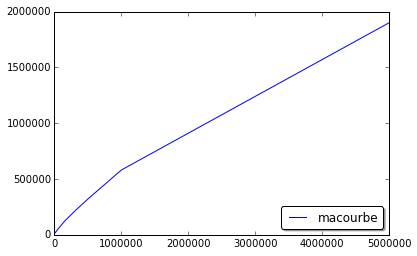

In [417]:
fig = plt.figure()
plt.plot(salaire_imposable_couple_2014, revdisp_maries_cesthra, label = "macourbe")
plt.legend(loc = 4, shadow=True, fancybox=True)
plt.xlim([0,salaire_maximal])

###### Graphique différence entre le revenu disponible du couple non-marié et celui du couple marié / revenu imposable

In [421]:
incitation_marriage_cesthra = revdisp_maries_cesthra - revdisp_celibataires_cesthra
incitation_marriage_cesthra

array([     0.  ,   4347.01,   7745.9 ,  13081.9 ,  15080.72,  17100.91,
        20349.12,  22322.94,  23838.08,  25353.22,  26868.41,  27514.38,
        28019.38,  28524.47,  29029.5 ,  29534.56,  30039.62,  30544.69,
        31049.69,  31554.75,  32059.81,  32079.75,  32079.75,  32079.75,
        32079.81,  32079.81,  32079.75,  32079.75,  32079.75,  32079.81,
        32079.81,  32079.81,  32079.88,  32079.81,  32079.81,  32079.88,
        32079.81,  32079.75,  32079.81,  32079.88,  32079.75,  32079.75,
        32079.75,  32079.75,  32079.88,  32079.75,  32079.75,  32079.75,
        32079.88,  32079.75,  32080.  ,  32079.88,  32079.75,  32079.75,
        32079.75,  32079.75,  32079.75,  32079.75,  32079.75,  32079.75,
        32079.75,  32079.75,  32079.75,  32079.75,  32079.75,  32079.75,
        32079.75,  32079.75,  32079.75,  32079.75,  32079.75,  32079.75,
        32079.75,  32079.75,  32079.5 ,  32079.75,  32079.75,  32079.75,
        32079.75,  32079.75,  32080.  ,  32079.75, 

(0, 5000000)

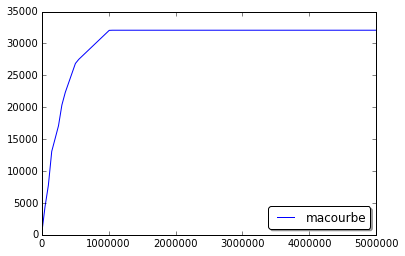

In [422]:
fig = plt.figure()
plt.plot(salaire_imposable_couple_2014, incitation_marriage_cesthra, label = "macourbe")
plt.legend(loc = 4, shadow=True, fancybox=True)
plt.xlim([0,salaire_maximal])

### III.2. Nouveau projet: Taxe Exceptionelle de Solidarité sur les Hautes Rémunérations (TEHR)

Définir Couple non-marié

In [423]:
def couple_celibataire_tehr(nombre_enfants = 0, year = 2015):
    enfant = [dict(
        birth = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    simulation = tax_benefit_system.new_scenario().init_single_entity(
        axes = [
            dict(
                count = 100,
                min = 0,
                max = salaire_maximal * 3,
                name = 'sal',
                ),
            ],
        period = "{}:3".format(year-2),
        parent1 = dict(
            birth = date(1980, 1, 1),
            statmarit = 2
            ),
        parent2 = dict(
            birth = date(1980, 1, 1),
            sal = 0,
            statmarit = 2
            ),
        menage = dict(
            loyer = 1000 * 3,
            so = 4,
            ),
        ).new_simulation(debug = True)
    return simulation

In [424]:
revdisp_celibataires_tehr = couple_celibataire_tehr().calculate('revdisp','2014')
print revdisp_celibataires_tehr
print len(revdisp_celibataires_tehr)

[    9037.46    42507.68    77269.15   107885.49   136134.53   163912.31
   190462.09   216724.72   242987.36   269250.     295512.59   321340.62
   347098.25   372855.81   398613.38   424370.94   450128.53   475886.06
   501643.69   527401.25   553158.81   578916.44   604674.     630431.56
   656189.12   681946.69   707704.31   733461.88   759219.44   784977.
   810734.56   836492.12   862249.75   888007.25   913764.81   939522.5
   965280.06   991037.62  1016795.19  1042552.75  1068310.25  1094067.88
  1119825.5   1145583.12  1171340.62  1197098.25  1222855.75  1248613.38
  1274370.88  1300128.5   1325886.    1351643.62  1377401.38  1403158.88
  1428916.5   1454674.    1480431.62  1506189.25  1531946.75  1557704.38
  1583461.88  1609219.5   1634977.    1660734.62  1686492.25  1712249.75
  1738007.25  1763764.88  1789522.38  1815280.    1841037.75  1866795.25
  1892552.88  1918310.38  1944068.    1969825.5   1995583.12  2021340.75
  2047098.25  2072855.75  2098613.5   2124371.    2150

In [426]:
salaire_imposable_couple_2014 = couple_celibataire_tehr().calculate('sal','2014')
salaire_imposable_couple_2014 = salaire_imposable_couple_2014[::2]
print salaire_imposable_couple_2014
print len(salaire_imposable_couple_2014)

[       0.      50505.05   101010.1    151515.16   202020.2    252525.25
   303030.31   353535.34   404040.41   454545.47   505050.5    555555.56
   606060.62   656565.69   707070.69   757575.75   808080.81   858585.81
   909090.94   959596.    1010101.    1060606.12  1111111.12  1161616.12
  1212121.25  1262626.25  1313131.38  1363636.38  1414141.38  1464646.5
  1515151.5   1565656.5   1616161.62  1666666.62  1717171.62  1767676.88
  1818181.88  1868686.88  1919192.    1969697.    2020202.    2070707.
  2121212.25  2171717.25  2222222.25  2272727.25  2323232.25  2373737.25
  2424242.5   2474747.5   2525252.5   2575757.5   2626262.75  2676767.75
  2727272.75  2777777.75  2828282.75  2878788.    2929293.    2979798.
  3030303.    3080808.    3131313.    3181818.25  3232323.25  3282828.25
  3333333.25  3383838.25  3434343.25  3484848.25  3535353.75  3585858.75
  3636363.75  3686868.75  3737373.75  3787878.75  3838384.    3888889.
  3939394.    3989899.    4040404.    4090909.    4141414.

Graphique Revenu disponible / revenu imposable

(0, 5000000)

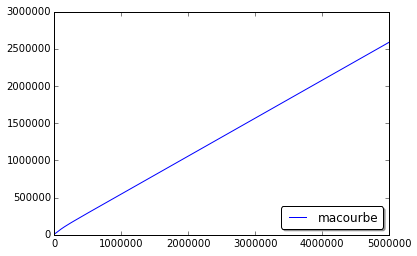

In [427]:
fig = plt.figure()
plt.plot(salaire_imposable_couple_2014, revdisp_celibataires_tehr, label = "macourbe")
plt.legend(loc = 4, shadow=True, fancybox=True)
plt.xlim([0,salaire_maximal])

Définir Couple marié

In [428]:
def couple_marie_tehr(nombre_enfants = 0, year = 2015):
    enfant = [dict(
        birth = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    simulation = tax_benefit_system.new_scenario().init_single_entity(
        axes = [
            dict(
                count = 100,
                min = 0,
                max = salaire_maximal * 3,
                name = 'sal',
                ),
            ],
        period = "{}:3".format(year-2),
        parent1 = dict(
            birth = date(1980, 1, 1),
            statmarit = 1
            ),
        parent2 = dict(
            birth = date(1980, 1, 1),
            sal = 0,
            statmarit = 1
            ),
        menage = dict(
            loyer = 1000 * 3,
            so = 4,
            ),
        ).new_simulation(debug = True)
    return simulation

In [429]:
revdisp_maries_tehr = couple_marie_tehr().calculate('revdisp','2014')
print revdisp_maries_tehr
print len(revdisp_maries_tehr)

[    9037.46    46854.68    85015.05   120967.39   151215.25   181013.22
   210811.22   239047.66   266825.44   294603.22   322381.     348855.
   375117.62   401380.28   427642.88   453905.5    480168.16   506430.75
   532693.38   558956.     585218.62   610996.25   636753.75   662511.31
   688268.94   714026.5    739784.06   765541.62   791299.19   817056.81
   842814.38   868571.94   894329.56   920087.06   945844.62   971602.31
   997359.88  1023117.38  1048875.    1074632.5   1100390.12  1126147.75
  1151905.25  1177662.88  1203420.5   1229178.    1254935.5   1280693.12
  1306450.75  1332208.38  1357965.88  1383723.5   1409481.12  1435238.62
  1460996.25  1486753.75  1512511.38  1538269.    1564026.5   1589784.12
  1615541.62  1641299.25  1667056.75  1692814.38  1718572.    1744329.5
  1770087.    1795844.62  1821602.12  1847359.75  1873117.5   1898875.
  1924632.62  1950390.12  1976147.62  2001905.25  2027662.88  2053420.5
  2079178.    2104935.5   2130693.    2156450.5   2182208

In [430]:
salaire_imposable_couple_2014 = couple_marie_tehr().calculate('sal','2014')
salaire_imposable_couple_2014 = salaire_imposable_couple_2014[::2]
print salaire_imposable_couple_2014
print len(salaire_imposable_couple_2014)

[       0.      50505.05   101010.1    151515.16   202020.2    252525.25
   303030.31   353535.34   404040.41   454545.47   505050.5    555555.56
   606060.62   656565.69   707070.69   757575.75   808080.81   858585.81
   909090.94   959596.    1010101.    1060606.12  1111111.12  1161616.12
  1212121.25  1262626.25  1313131.38  1363636.38  1414141.38  1464646.5
  1515151.5   1565656.5   1616161.62  1666666.62  1717171.62  1767676.88
  1818181.88  1868686.88  1919192.    1969697.    2020202.    2070707.
  2121212.25  2171717.25  2222222.25  2272727.25  2323232.25  2373737.25
  2424242.5   2474747.5   2525252.5   2575757.5   2626262.75  2676767.75
  2727272.75  2777777.75  2828282.75  2878788.    2929293.    2979798.
  3030303.    3080808.    3131313.    3181818.25  3232323.25  3282828.25
  3333333.25  3383838.25  3434343.25  3484848.25  3535353.75  3585858.75
  3636363.75  3686868.75  3737373.75  3787878.75  3838384.    3888889.
  3939394.    3989899.    4040404.    4090909.    4141414.

Graphique Revenu disponible / revenu imposable

(0, 5000000)

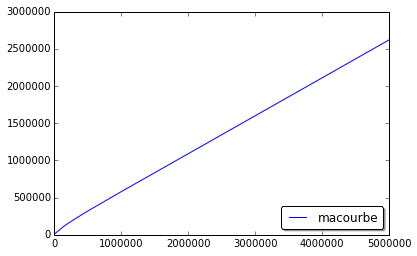

In [431]:
fig = plt.figure()
plt.plot(salaire_imposable_couple_2014, revdisp_maries_tehr, label = "macourbe")
plt.legend(loc = 4, shadow=True, fancybox=True)
plt.xlim([0,salaire_maximal])

###### Graphique différence entre le revenu disponible du couple non-marié et celui du couple marié / revenu imposable

In [432]:
incitation_marriage_tehr = revdisp_maries_tehr - revdisp_celibataires_tehr
incitation_marriage_tehr

array([     0.  ,   4347.01,   7745.9 ,  13081.9 ,  15080.72,  17100.91,
        20349.12,  22322.94,  23838.08,  25353.22,  26868.41,  27514.38,
        28019.38,  28524.47,  29029.5 ,  29534.56,  30039.62,  30544.69,
        31049.69,  31554.75,  32059.81,  32079.81,  32079.75,  32079.75,
        32079.81,  32079.81,  32079.75,  32079.75,  32079.75,  32079.81,
        32079.81,  32079.81,  32079.81,  32079.81,  32079.81,  32079.81,
        32079.81,  32079.75,  32079.81,  32079.75,  32079.88,  32079.88,
        32079.75,  32079.75,  32079.88,  32079.75,  32079.75,  32079.75,
        32079.88,  32079.88,  32079.88,  32079.88,  32079.75,  32079.75,
        32079.75,  32079.75,  32079.75,  32079.75,  32079.75,  32079.75,
        32079.75,  32079.75,  32079.75,  32079.75,  32079.75,  32079.75,
        32079.75,  32079.75,  32079.75,  32079.75,  32079.75,  32079.75,
        32079.75,  32079.75,  32079.62,  32079.75,  32079.75,  32079.75,
        32079.75,  32079.75,  32079.5 ,  32079.5 , 

(0, 5000000)

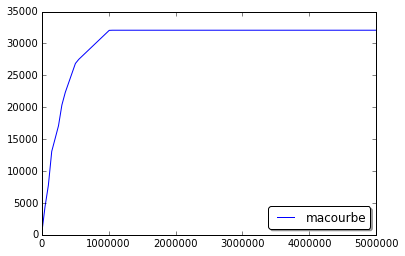

In [433]:
fig = plt.figure()
plt.plot(salaire_imposable_couple_2014, incitation_marriage_tehr, label = "macourbe")
plt.legend(loc = 4, shadow=True, fancybox=True)
plt.xlim([0,salaire_maximal])

### III.3. Différence d'incitation au marriage entre les deux réformes

In [434]:
Difference_incitation_2_reformes = incitation_marriage_cesthra - incitation_marriage_tehr
print Difference_incitation_2_reformes
print len(Difference_incitation_2_reformes)

[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   -0.06  0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.06  0.    0.    0.06  0.    0.    0.
  0.12 -0.12 -0.12  0.    0.    0.    0.    0.    0.    0.   -0.12  0.12
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.12  0.    0.
  0.    0.    0.    0.5   0.25  0.   -0.25  0.    0.25  0.25  0.    0.    0.
  0.    0.    0.25  0.    0.    0.    0.    0.    0.25  0.  ]
100


(0, 5000000)

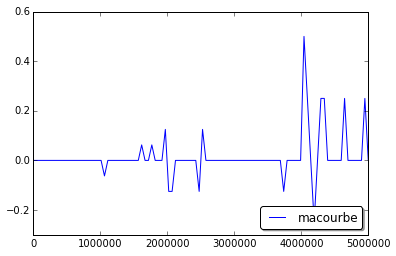

In [436]:
fig = plt.figure()
plt.plot(salaire_imposable_couple_2014, Difference_incitation_2_reformes, label = "macourbe")
plt.legend(loc = 4, shadow=True, fancybox=True)
plt.xlim([0,salaire_maximal])

## Conclusion

In [34]:
Test dde la reforme code :

SyntaxError: invalid syntax (<ipython-input-34-bdcc5c7966b0>, line 1)

In [35]:
import datetime



from openfisca_core import periods
import openfisca_france
from openfisca_france.reforms import plf2015
from openfisca_france.tests import base

TaxBenefitSystem = openfisca_france.init_country()
tax_benefit_system = TaxBenefitSystem()


def test(year = 2014):
    max_sal = 2000000
    count = 10
    people = 1
    reform = Reform
    scenario = reform.new_scenario().init_single_entity(
        axes = [
            dict(
                count = count,
                max = max_sal,
                min = 900000,
                name = 'sal',
                ),
            ],
        period = periods.period('year', year),
        parent1 = dict(birth = datetime.date(year - 40, 1, 1)),
        parent2 = dict(birth = datetime.date(year - 40, 1, 1)) if people >= 2 else None,
        enfants = [
            dict(birth = datetime.date(year - 9, 1, 1)) if people >= 3 else None,
            dict(birth = datetime.date(year - 9, 1, 1)) if people >= 4 else None,
            ] if people >= 3 else None,
        )

    reference_simulation = scenario.new_simulation(debug = True, reference = True)
    reform_simulation = scenario.new_simulation(debug = True)

    error_margin = 0.1
    impo = reference_simulation.calculate('impo')
    reform_impo = reform_simulation.calculate('impo')
    print impo
    print reform_impo


if __name__ == '__main__':
    import logging
    import sys
    logging.basicConfig(level = logging.ERROR, stream = sys.stdout)
    test()


[-402992.6875 -462881.5938 -522770.5    -582659.375  -642548.25   -702437.125
 -762326.     -822214.875  -882103.8125 -941992.6875]
[ -402992.6875  -466881.5938  -548770.5     -630659.375   -712548.25
  -794437.125   -876326.      -958214.875  -1040103.8125 -1121992.75  ]
